<a href="https://colab.research.google.com/github/MaxGhenis/taxcalc-notebooks/blob/master/synth/synthetic_cps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Quantile regression from OLS to TensorFlow](#scrollTo=PQdJbWCS9N3G)

>>[Setup](#scrollTo=VjvK4vP2-X_D)

>>>[Graph options](#scrollTo=sm3RTN850S70)

>>>[Data](#scrollTo=vdaqXkSCe7gG)

>>>>[Load](#scrollTo=vdaqXkSCe7gG)

>>>[Preprocess](#scrollTo=SJhy87dDRHOU)

>>>>[Randomize and split](#scrollTo=80yZ1lihmLQq)

>>>>[Normalize](#scrollTo=xuphFNDqtEiW)

>>>>[Data for two-stage logit+OLS](#scrollTo=rsEPQ7D5CVvY)

>>>[Initialize result](#scrollTo=utzAT-gdBTqj)

>>[OLS](#scrollTo=6dRLoTDhCrpO)

>>[Logit + OLS](#scrollTo=dcIdeWX_TRX8)

>>>[Predict](#scrollTo=O-ccxbmpmfmr)

>>[QuantReg](#scrollTo=esTAKyTyG1TS)

>>[Random forests](#scrollTo=qCt2S4V9Uepc)

>>[Gradient boosted trees](#scrollTo=6ssXXxsCA7FS)

>>[Keras](#scrollTo=H55y_74W97jH)

>>[TensorFlow](#scrollTo=PEy2M6X89tbD)

>>[Compare quantile loss](#scrollTo=42LIBXl933YI)



# Synthetic CPS


Use the [CPS data.](https://github.com/open-source-economics/taxdata/blob/master/cps_data/cps.csv.gz)

## Setup

In [0]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import linear_model

Random forest and GBM options.

In [0]:
N_ESTIMATORS = 40

### Graph options

In [3]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

--2018-11-10 05:35:16--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2018-11-10 05:35:16--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/Roboto-Regular.ttf’

Roboto-Regular.ttf  100%[===================>] 141.94K  --.-KB/s    in 0.04s   

2018-11-10 05:35:16

In [0]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

### Data

#### Load

In [0]:
raw = pd.read_csv('https://github.com/open-source-economics/taxdata/raw/master/cps_data/cps.csv.gz')

### Preprocess

Take 10% sample and drop identifiers and other fields unnecessary for synthesis ([source](http://open-source-economics.github.io/Tax-Calculator/)):

* `RECID`: Unique numeric identifier for filing unit; appears as RECID variable in tc CLI minimal output
* `h_seq`:  CPS household sequence number (not used in tax-calculation logic)
* `ffpos`: CPS family identifier within household (not used in tax-calculation logic)
* `a_lineno`: CPS line number for the person record of the head of the tax filing unit (not used in tax-calculation)
* `agi_bin`: Historical AGI category used in data extrapolation...not used in tax calculations
* `filer`: 1 if unit files an income tax return; 0 if not (not used in tax-calculation logic); in the puf.csv file a value of 1 indicates record is from IRS/SOI PUF and 0 indicates record is from CPS
* `fips`: FIPS state code (not used in tax-calculation logic)
* `FLPDYR`: Calendar year for which taxes are calculated
* `pencon_s` and `pencon_p`: Zero in CPS.

In [0]:
DROP_VARS = ['RECID', 'h_seq', 'ffpos', 'a_lineno', 'agi_bin', 'filer', 
             'fips', 'FLPDYR', 'pencon_s', 'pencon_p']

In [0]:
SAMPLE_FRAC = 1.0
dat = raw.sample(frac=SAMPLE_FRAC).drop(DROP_VARS, axis=1)

Set variables with under 10 distinct values to string for classification.

In [8]:
dat.T.apply(lambda x: x.nunique(), axis=1).sort_values().head(20)

DSI                     2
blind_head              2
blind_spouse            2
MARS                    3
EIC                     4
elderly_dependents      4
nu05                    5
n1820                   7
mcare_ben               9
n21                     9
f2441                  11
n24                    11
nu13                   11
nu18                   13
XTOT                   14
mcaid_ben              14
age_head               82
age_spouse             82
e00800                126
e03240                548
dtype: int64

In [0]:
var_nunique = dat.T.apply(lambda x: x.nunique(), axis=1)

In [10]:
class_vars = var_nunique[var_nunique < 10].index.tolist()
class_vars

['DSI',
 'blind_head',
 'blind_spouse',
 'n1820',
 'n21',
 'mcare_ben',
 'nu05',
 'elderly_dependents',
 'EIC',
 'MARS']

Split into test and train.

In [0]:
train, test = train_test_split(dat, test_size=0.5, random_state=42)

In [12]:
# Only make train fields strings, since it's just for modeling. 
# Convert back later.
train[class_vars] = train[class_vars].astype(str)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


## Functions

From https://stackoverflow.com/a/52615768/1840471

In [0]:
def percentile_qarray_np(dat, q):
  return np.apply_along_axis(
    lambda x: np.percentile(x[1:], x[0]),
    1,
    np.concatenate([np.array(q)[:, np.newaxis], dat], axis=1)
  )

In [0]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return percentile_qarray_np(rf_preds, q * 100)

## Synthesize

Seed variables should be those whose combination would be freely published by the IRS.

In [0]:
SEED_COLS = ['MARS', 'XTOT', 'age_head']

In [0]:
synth = train.copy()[SEED_COLS]  # Copy to avoid a warning.

In [0]:
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose=True, 
                                    n_jobs=-1)  # Use maximum number of cores.

### Set order of feature synthesis

Start with demographic columns, then income, then benefits, then weight.

In [0]:
DEMO_COLS = ['MARS', 'XTOT', 'age_head', 
             'age_spouse', 'blind_head', 'blind_spouse', 'DSI',
             'nu05', 'nu13', 'n24', 'nu18', 'n1820', 'n21',
             'elderly_dependents',
             'f2441', 'EIC']
demo_cols = list(set(DEMO_COLS) - set(SEED_COLS))
ben_cols = [x for x in test.columns if x.endswith('_ben')]
income_cols = list(set(test.columns) - set(demo_cols) - set(ben_cols) - 
                   set(['s006']) - set(SEED_COLS))

In [0]:
rf_vars = demo_cols + income_cols + ben_cols + ['s006']

In [20]:
for i, col in enumerate(rf_vars):
  print('Synthesizing feature ' + str(i + 1) + ' of ' + 
        str(len(rf_vars)) + ': ' + col + '...')
  rf.fit(train[synth.columns], train[col])
  synth[col] = rf_quantile(rf, synth, np.random.rand(synth.shape[0]))

Synthesizing feature 1 of 56: nu18...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.2s finished


Synthesizing feature 2 of 56: n21...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.4s finished


Synthesizing feature 3 of 56: blind_spouse...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.0s finished


Synthesizing feature 4 of 56: nu05...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


Synthesizing feature 5 of 56: f2441...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.6s finished


Synthesizing feature 6 of 56: elderly_dependents...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.5s finished


Synthesizing feature 7 of 56: nu13...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


Synthesizing feature 8 of 56: age_spouse...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.9s finished


Synthesizing feature 9 of 56: blind_head...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.8s finished


Synthesizing feature 10 of 56: DSI...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.5s finished


Synthesizing feature 11 of 56: EIC...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.0s finished


Synthesizing feature 12 of 56: n24...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.2s finished


Synthesizing feature 13 of 56: n1820...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.6s finished


Synthesizing feature 14 of 56: e20100...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.4s finished


Synthesizing feature 15 of 56: e00300...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   35.8s finished


Synthesizing feature 16 of 56: e01400...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   32.8s finished


Synthesizing feature 17 of 56: e19200...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   37.6s finished


Synthesizing feature 18 of 56: e00900p...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


Synthesizing feature 19 of 56: e02100p...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.6min finished


Synthesizing feature 20 of 56: e00600...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.9min finished


Synthesizing feature 21 of 56: e20400...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


Synthesizing feature 22 of 56: e02300...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


Synthesizing feature 23 of 56: e00900...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


Synthesizing feature 24 of 56: e17500...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


Synthesizing feature 25 of 56: e32800...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   43.5s finished


Synthesizing feature 26 of 56: e00650...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.0min finished


Synthesizing feature 27 of 56: e00900s...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


Synthesizing feature 28 of 56: e02100s...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished


Synthesizing feature 29 of 56: e18500...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


Synthesizing feature 30 of 56: e03210...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


Synthesizing feature 31 of 56: e03270...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished


Synthesizing feature 32 of 56: e03300...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.2min finished


Synthesizing feature 33 of 56: e03150...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


Synthesizing feature 34 of 56: e18400...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


Synthesizing feature 35 of 56: e00200s...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


Synthesizing feature 36 of 56: e03240...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.0min finished


Synthesizing feature 37 of 56: e00200p...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.1min finished


Synthesizing feature 38 of 56: e19800...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


Synthesizing feature 39 of 56: e01100...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.3min finished


Synthesizing feature 40 of 56: e02400...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.4min finished


Synthesizing feature 41 of 56: e01700...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.4min finished


Synthesizing feature 42 of 56: e01500...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.3min finished


Synthesizing feature 43 of 56: e00200...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


Synthesizing feature 44 of 56: e00800...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.9min finished


Synthesizing feature 45 of 56: e00400...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


Synthesizing feature 46 of 56: e02100...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.4min finished


Synthesizing feature 47 of 56: ssi_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished


Synthesizing feature 48 of 56: vet_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.8min finished


Synthesizing feature 49 of 56: snap_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


Synthesizing feature 50 of 56: mcare_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.3min finished


Synthesizing feature 51 of 56: mcaid_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.9min finished


Synthesizing feature 52 of 56: tanf_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.5min finished


Synthesizing feature 53 of 56: housing_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


Synthesizing feature 54 of 56: wic_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished


Synthesizing feature 55 of 56: other_ben...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


Synthesizing feature 56 of 56: s006...


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.4min finished


## Evaluate

Compare CDFs and correlations to test data.

In [0]:
synthr = synth.round()

In [0]:
def cdf(df, col):
  res = df[[col, 's006']].sort_values(col)
  res['s006_cumpct'] = res.s006.cumsum() / res.s006.sum()
  return res

In [0]:
from matplotlib.ticker import MaxNLocator

def compare_cdf(synth, test, col, unit_prepend=''):
  synth_cdf = cdf(synth, col)
  test_cdf = cdf(test, col)
  ax = synth_cdf.plot(x=col, y='s006_cumpct')
  test_cdf.plot(x=col, y='s006_cumpct', ax=ax, color='#BDBDBD')
  ax.legend(['Synthetic', 'Test'])
  ax.grid(color='#eeeeee')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  # Assume a dollar amount if exceeds 100. Use symlog and $ axis.
  if test[col].max() > 100:
    unit_prepend = '$'
    plt.xscale('symlog')
  ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
      lambda x, _: unit_prepend + format(int(x), ',')))
  ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
      lambda y, _: '{:.0%}'.format(y)))
  ax.set(xlabel=col, ylabel='Share of tax units')
  plt.title('CDF of ' + col + ' for synthetic and test sets', loc='left')
  sns.despine(left=True, bottom=True)
  plt.show()

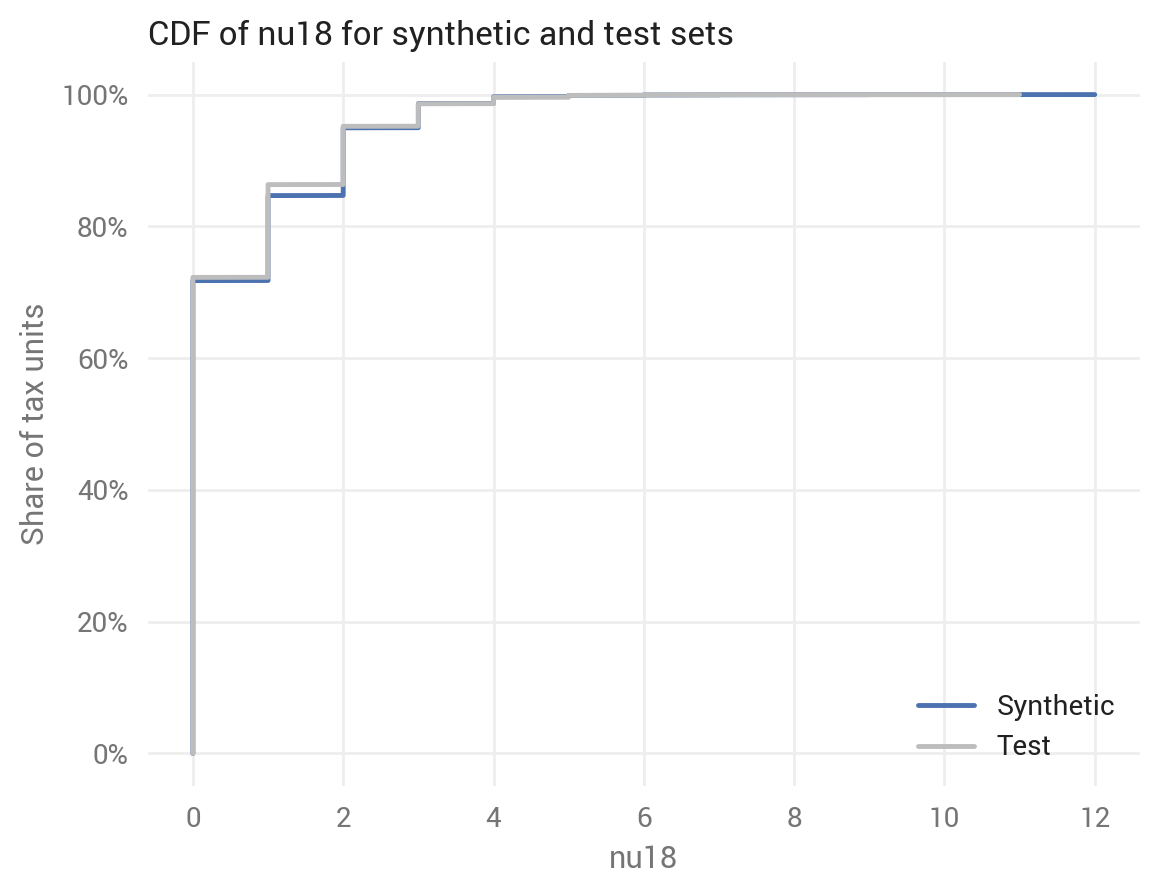

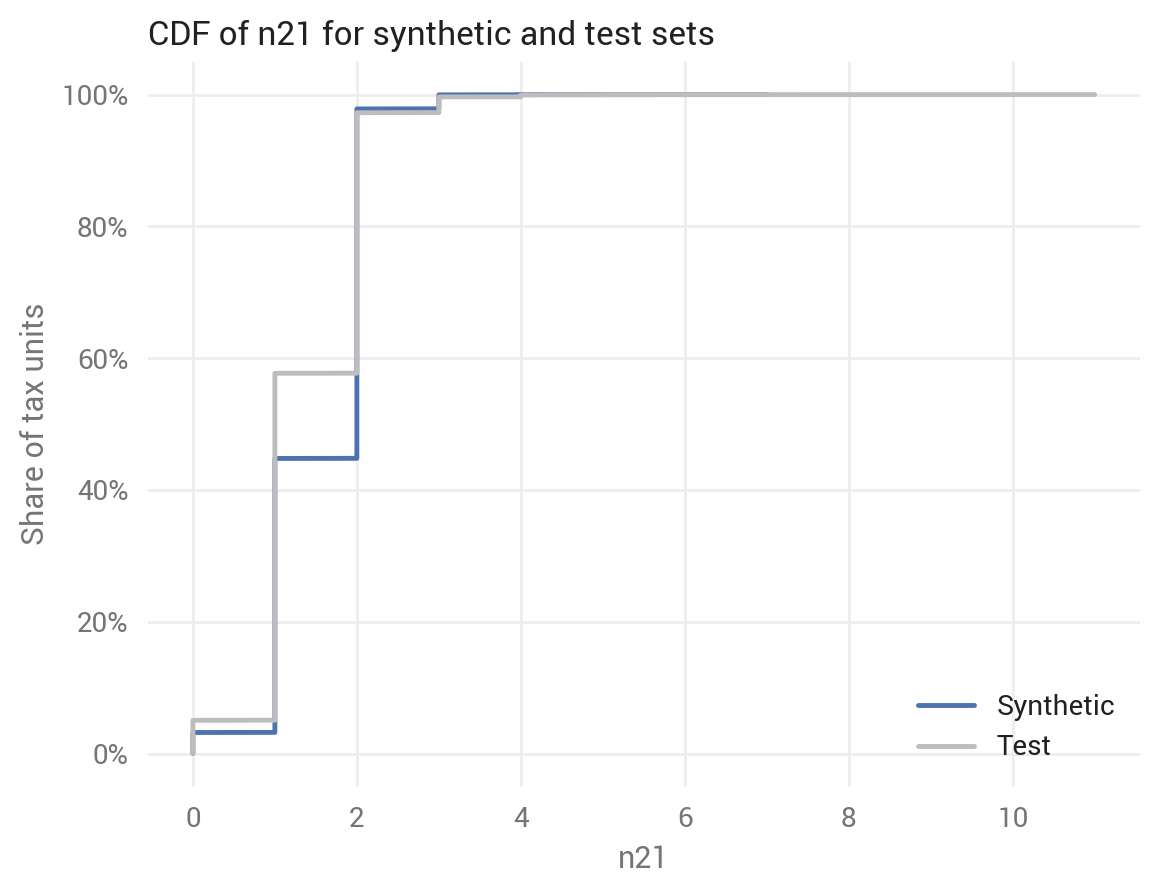

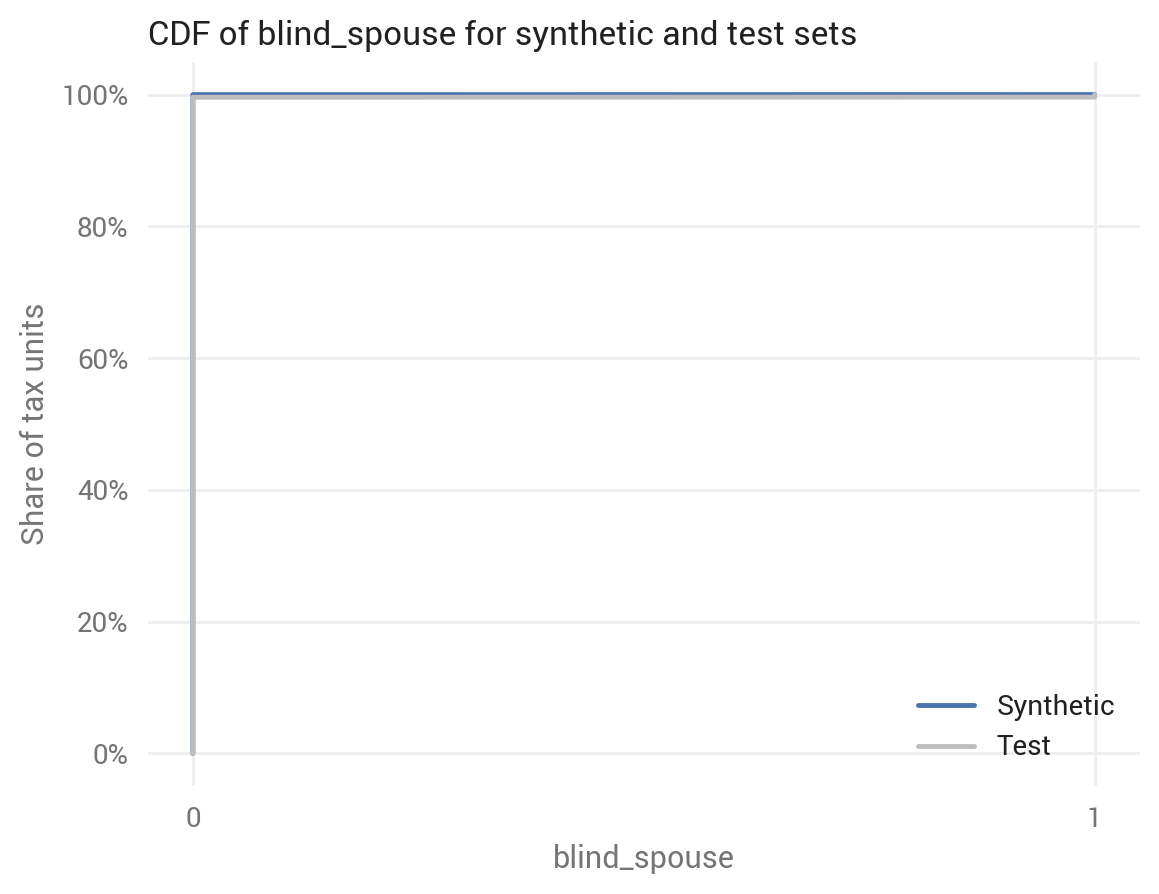

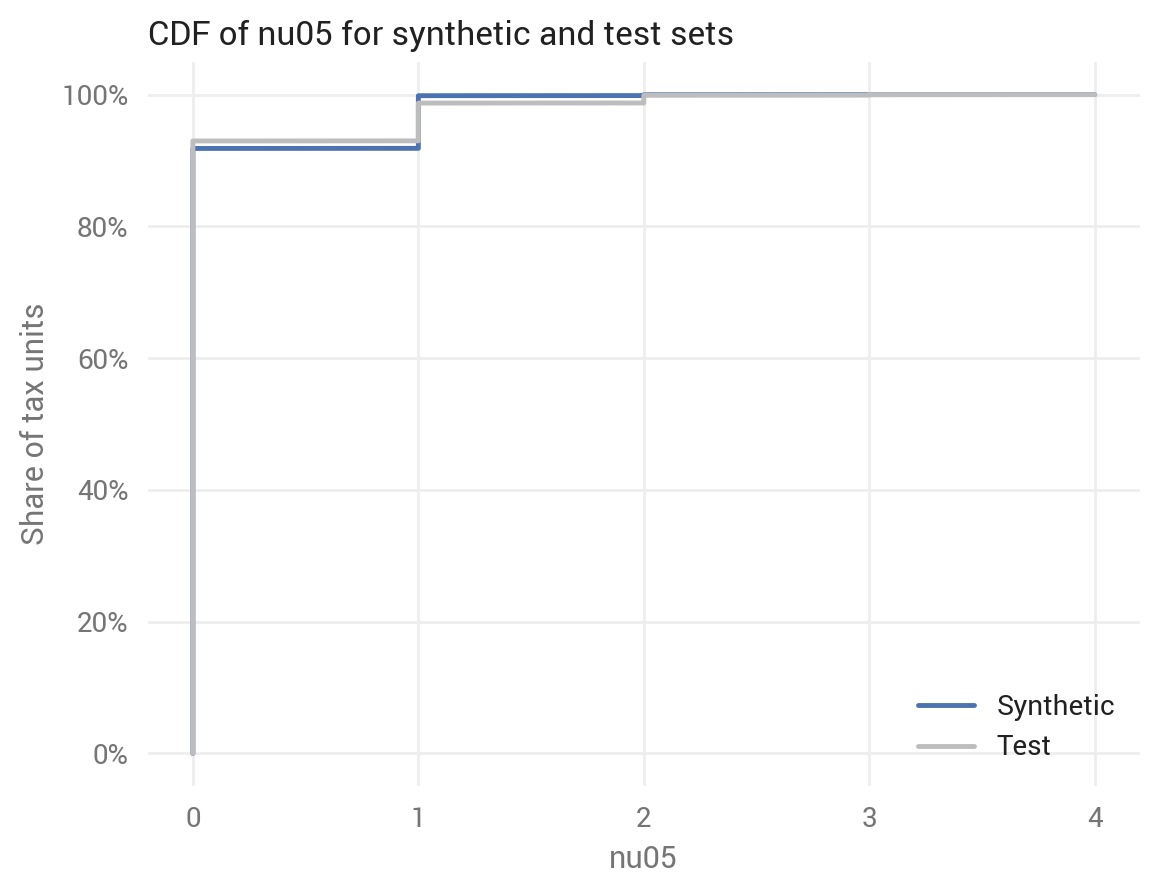

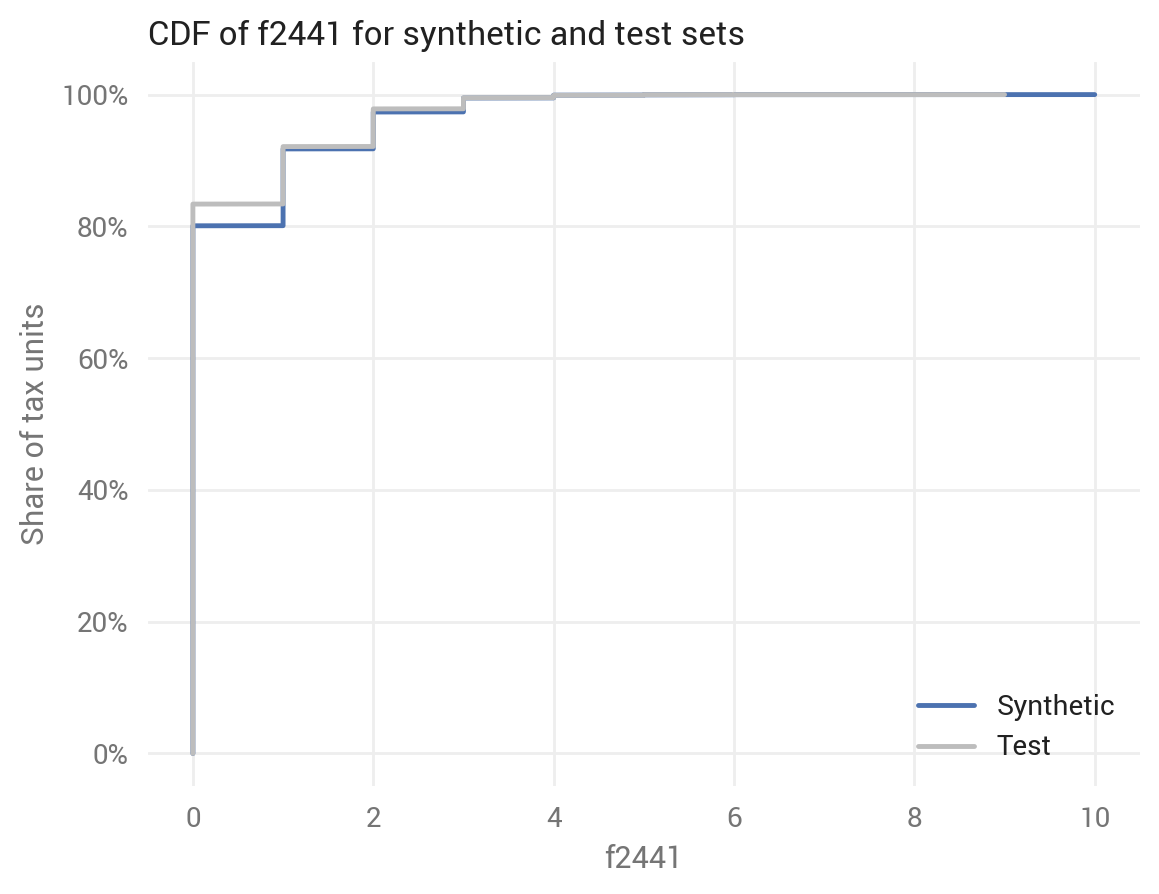

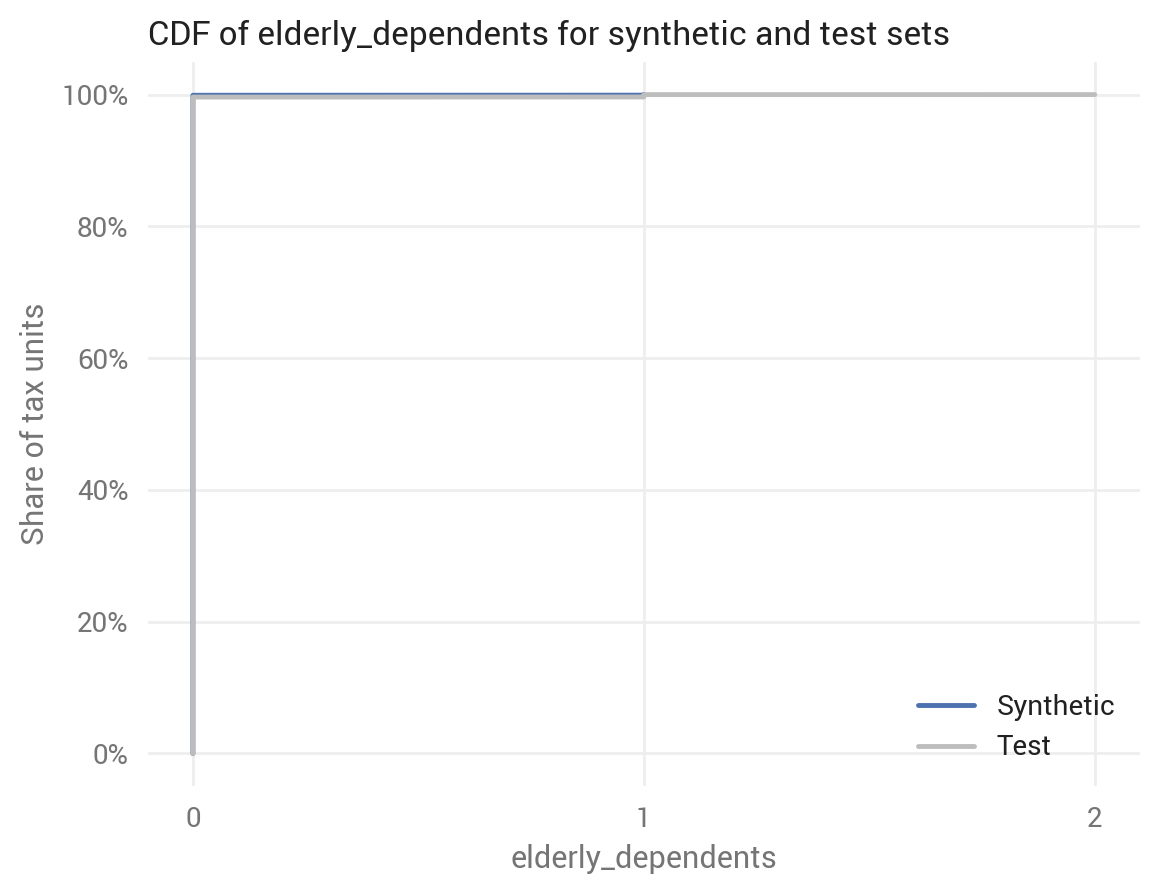

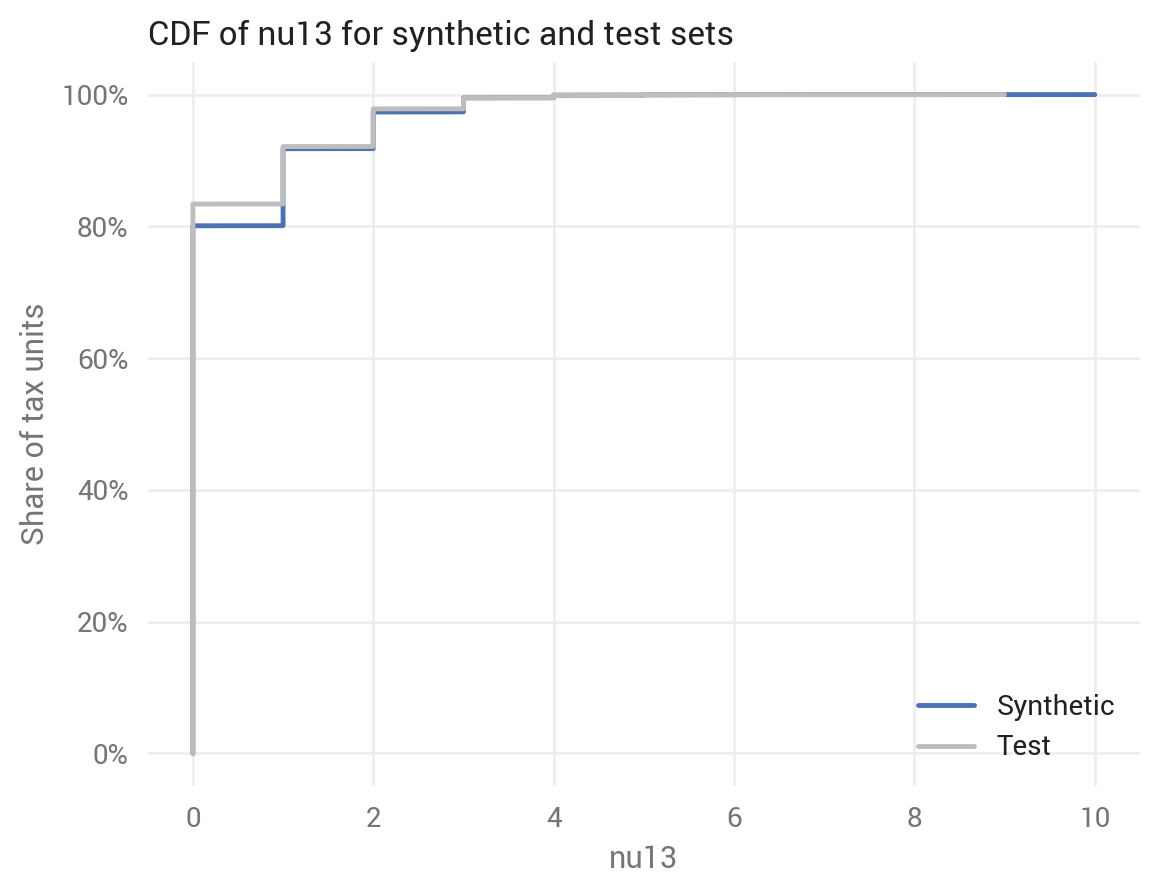

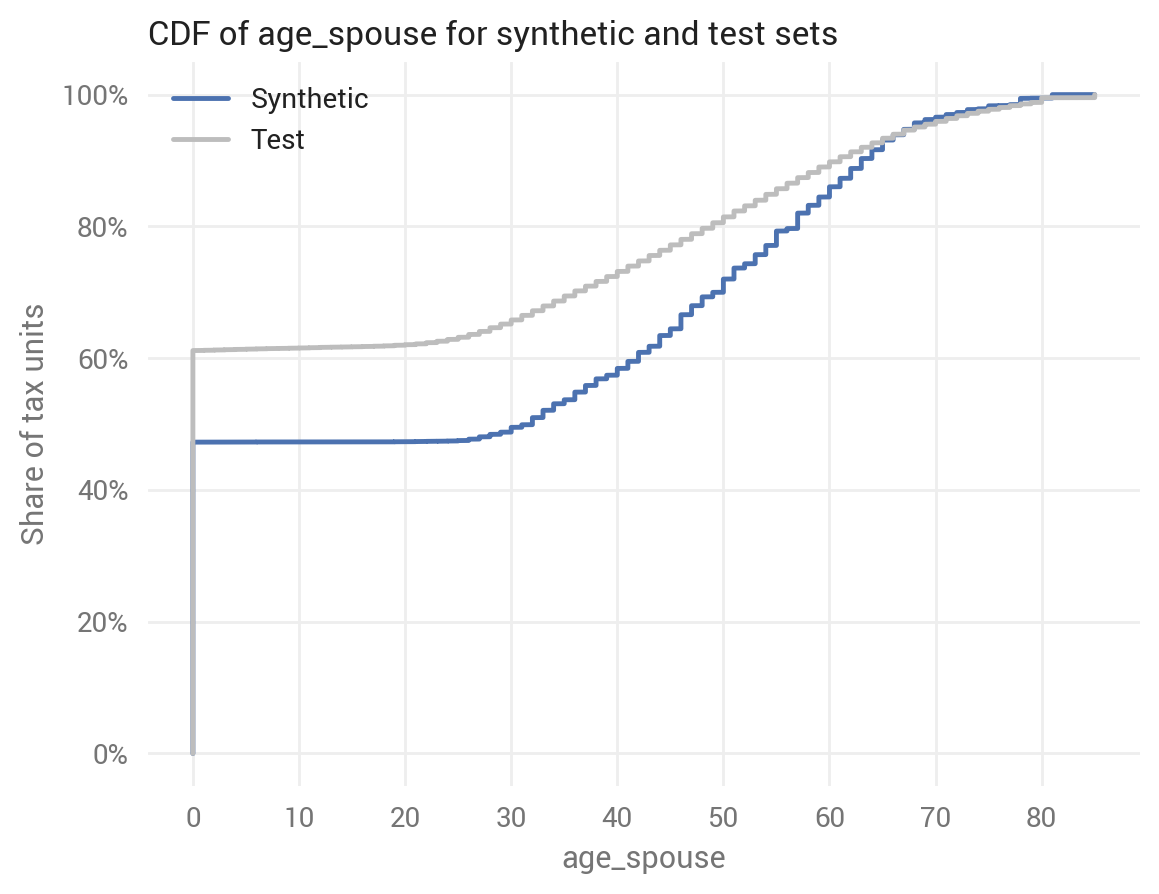

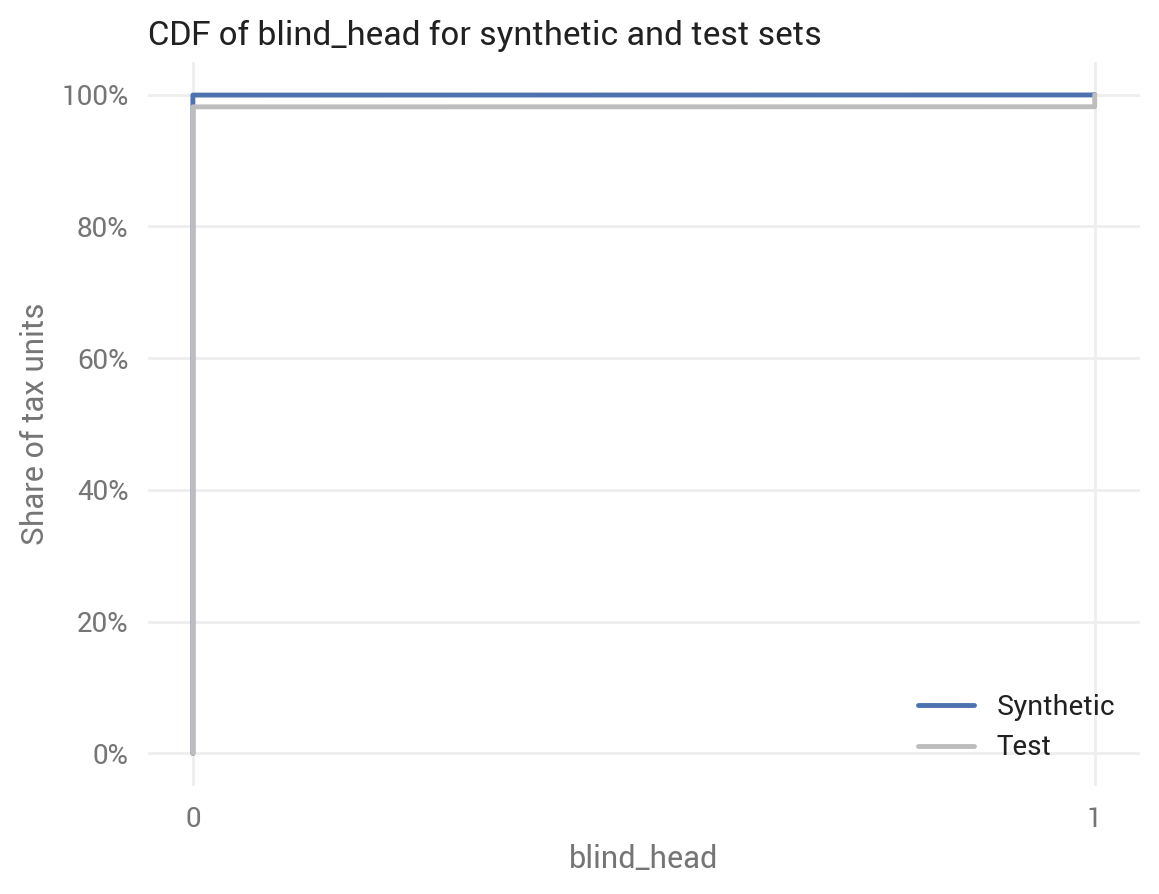

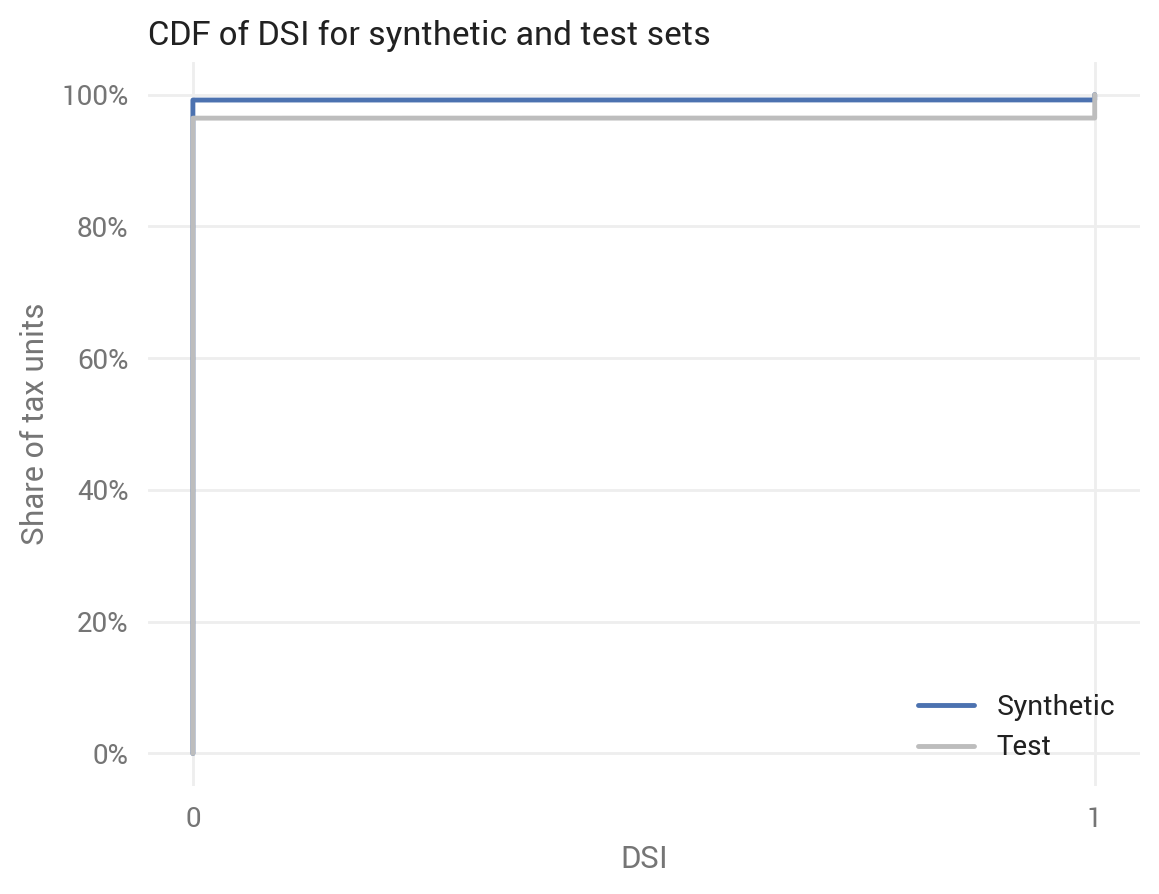

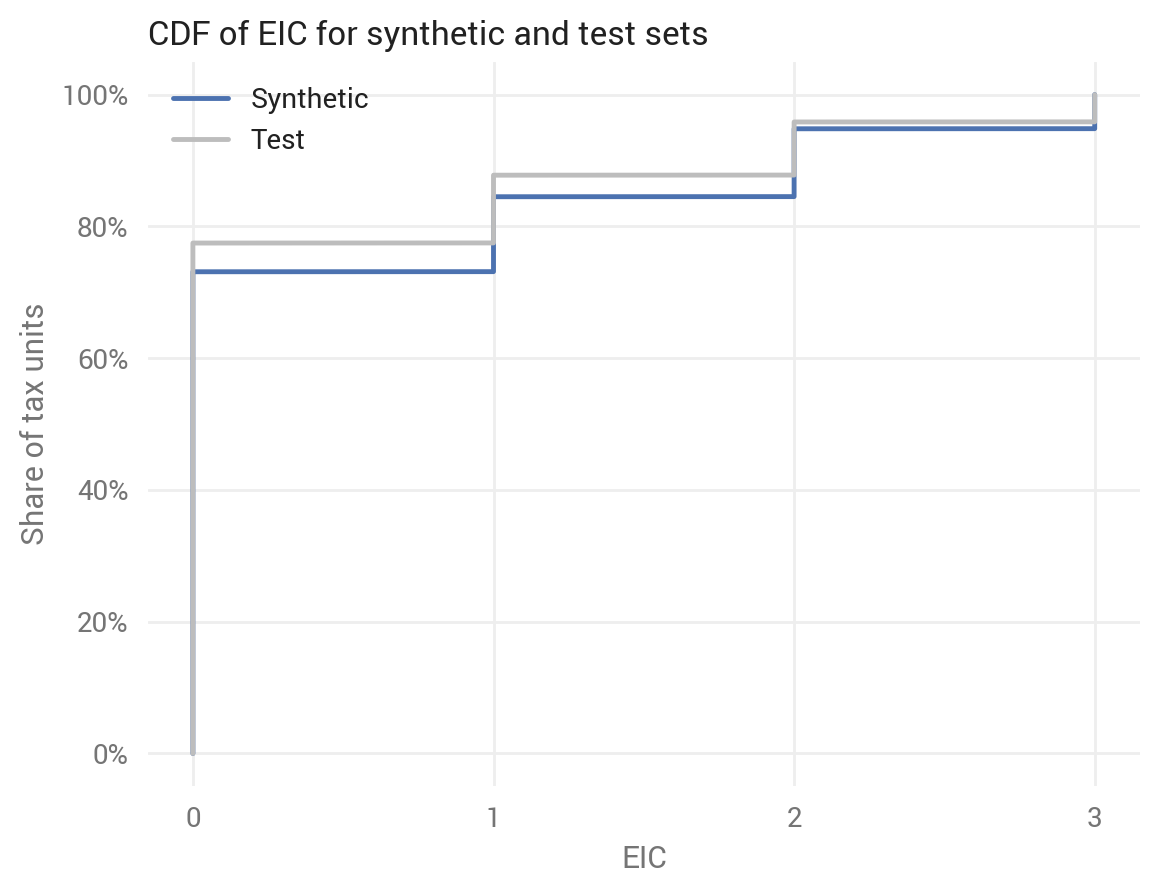

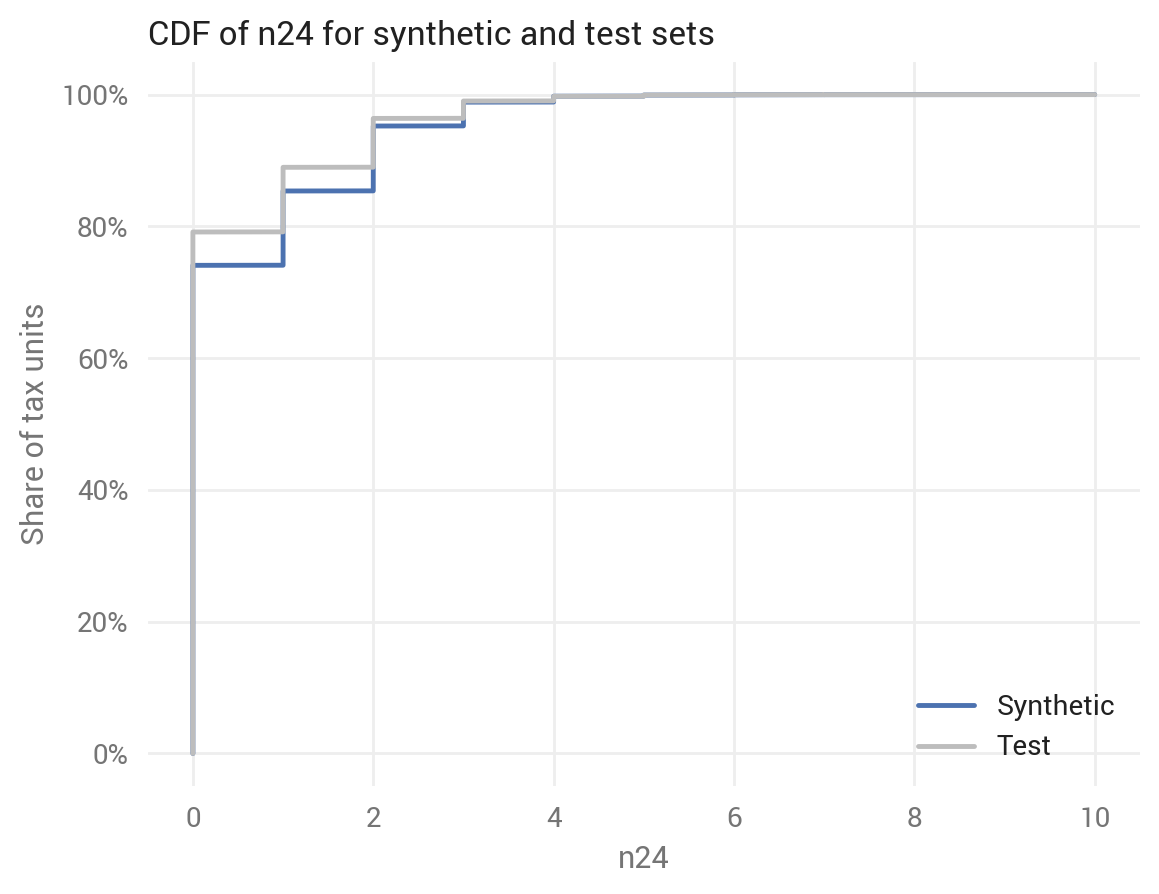

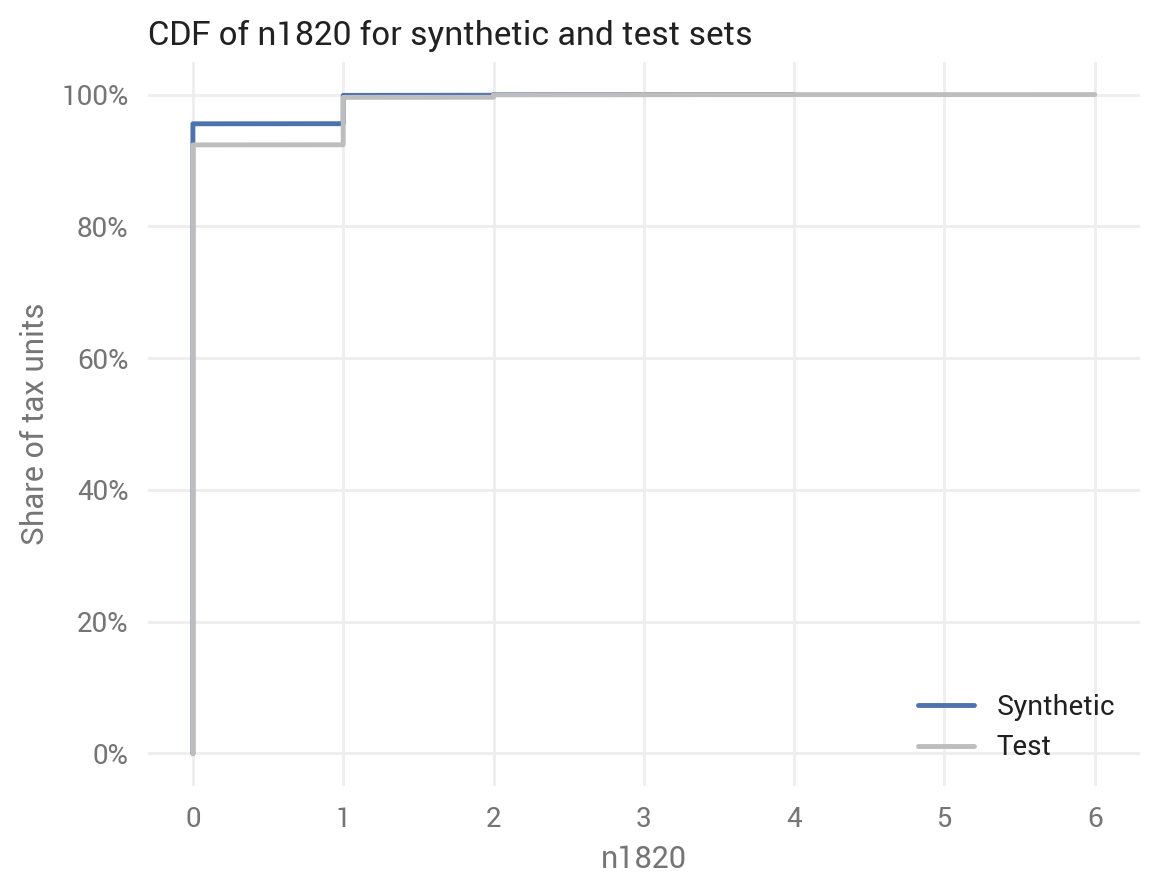

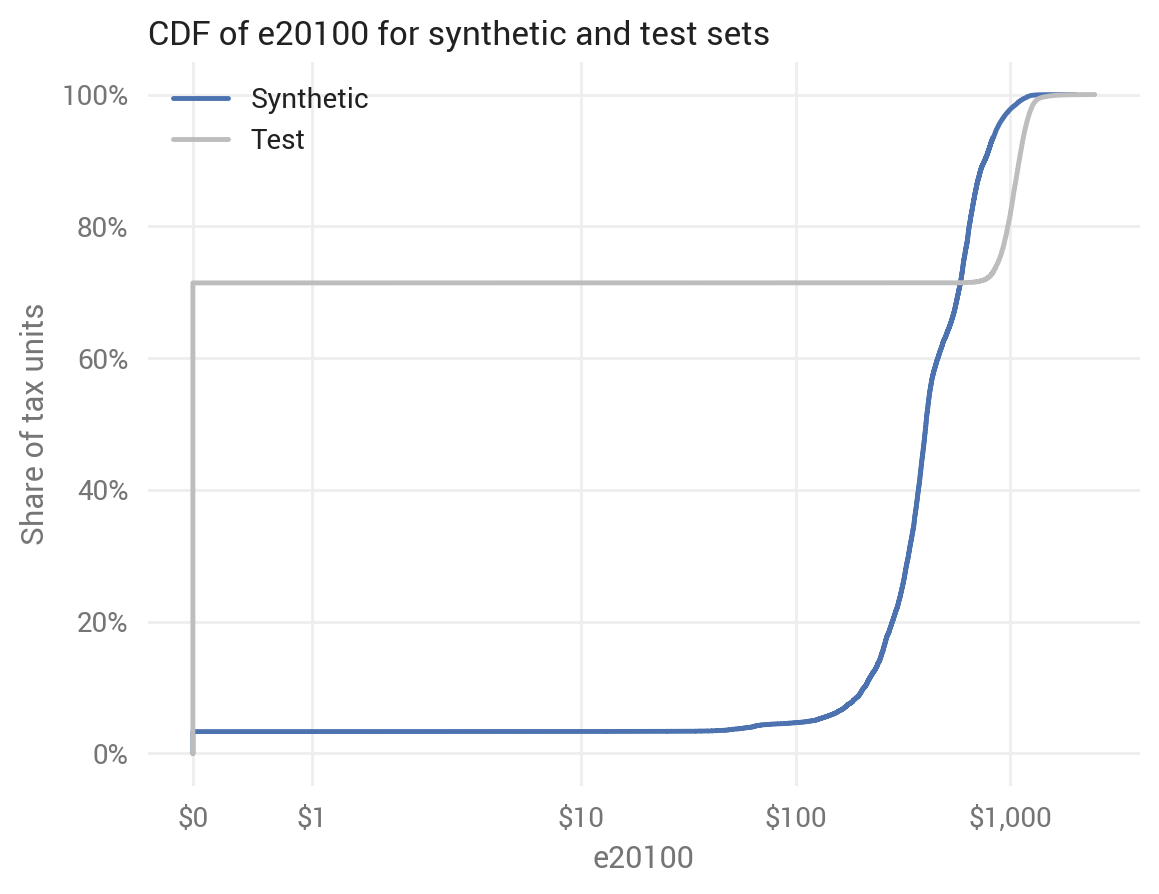

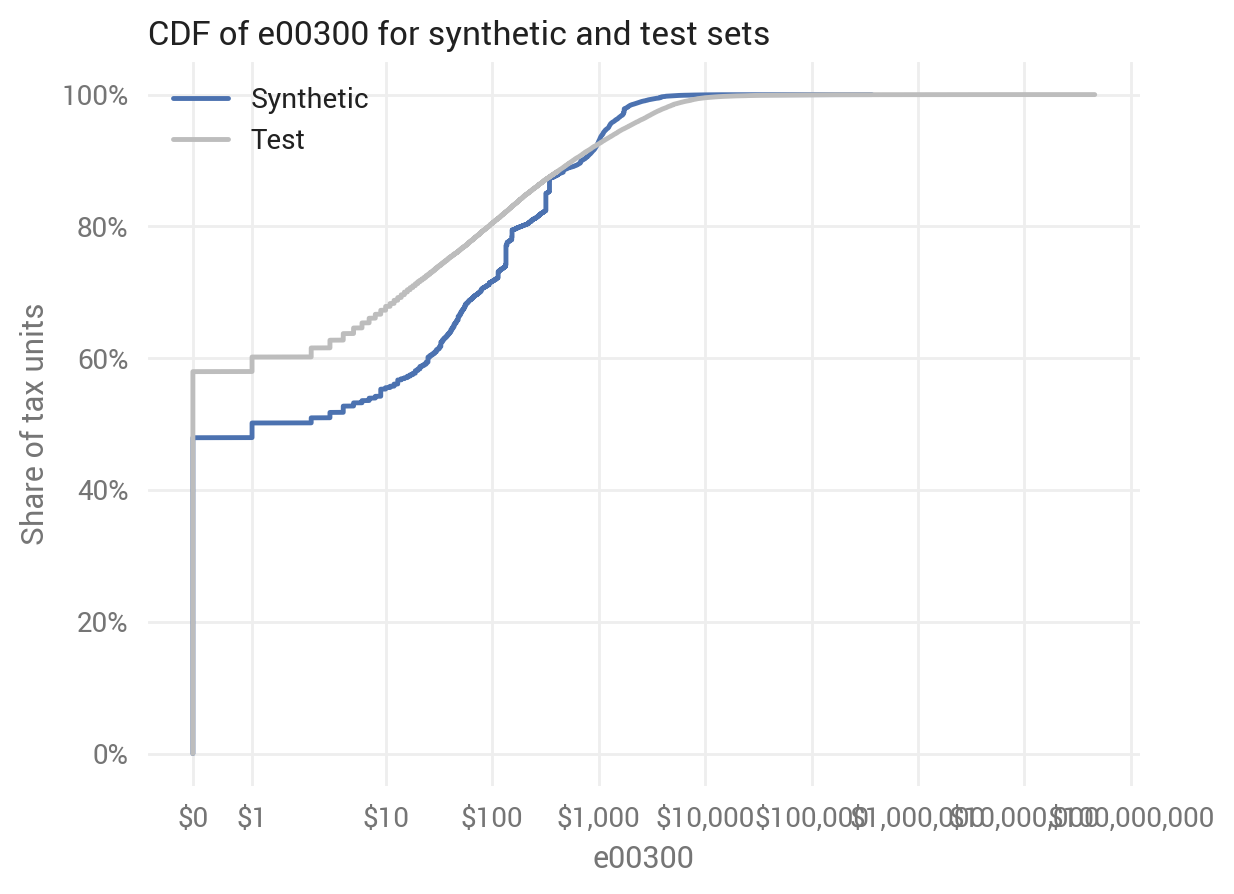

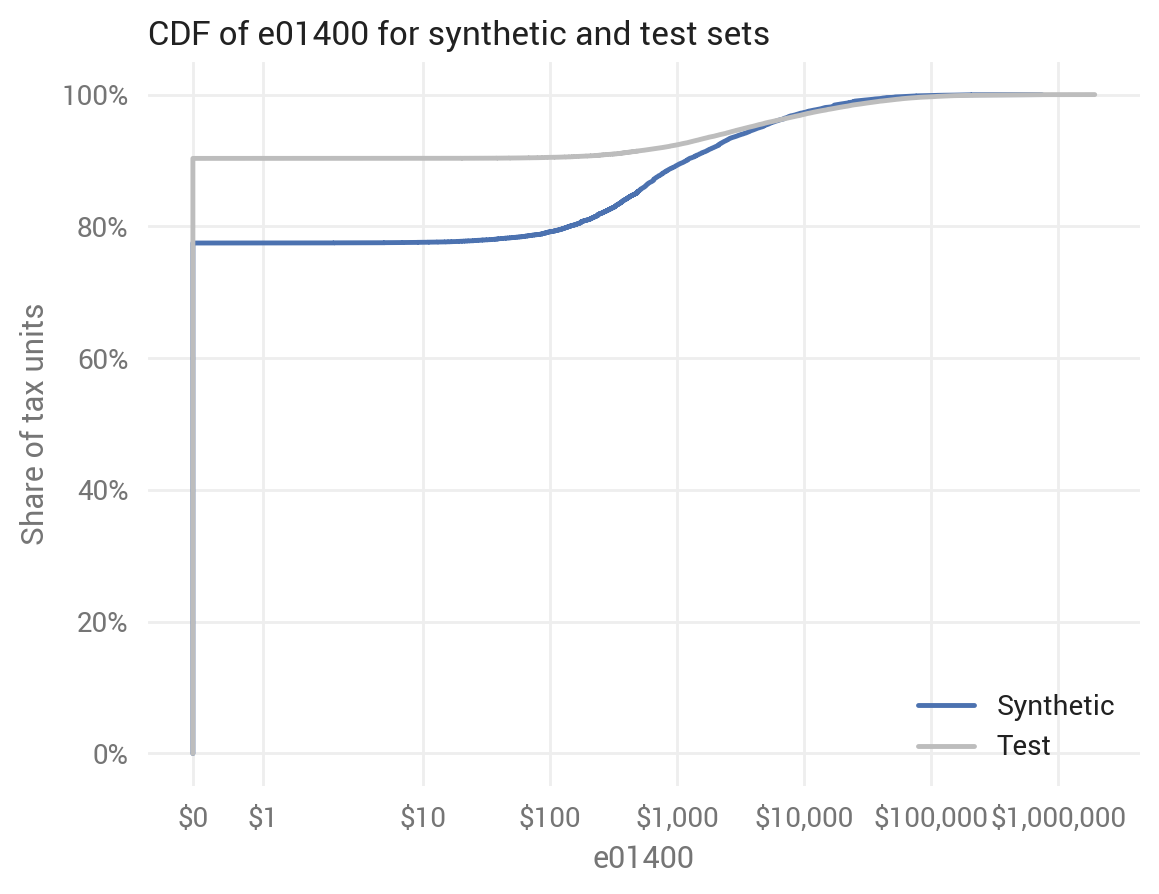

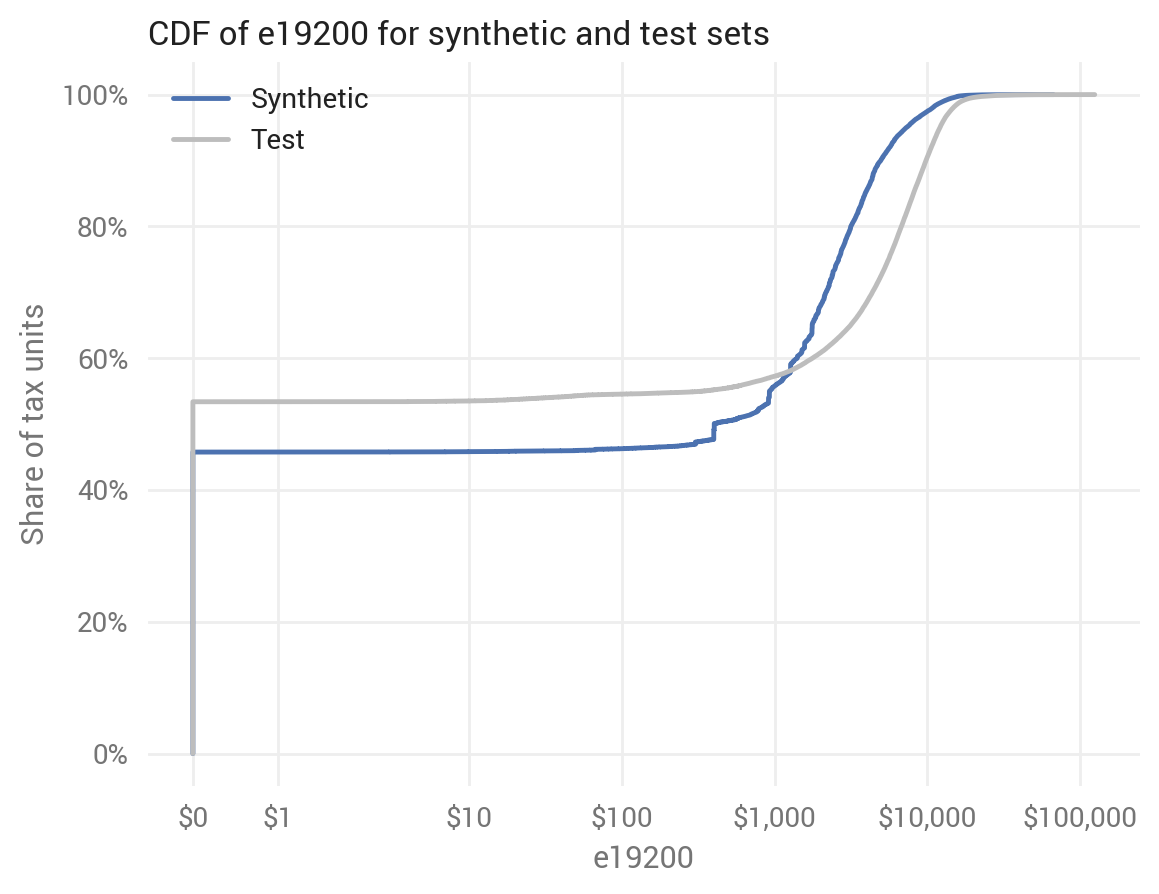

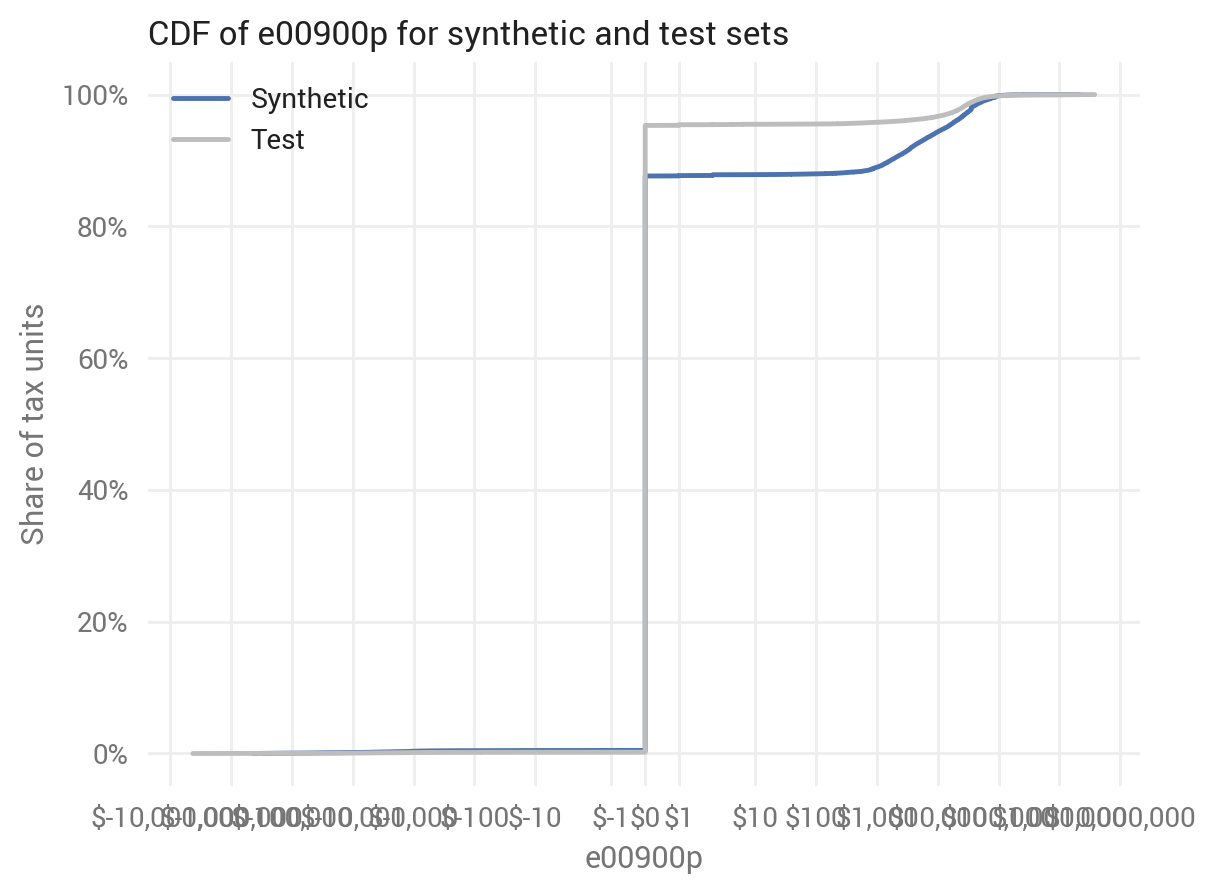

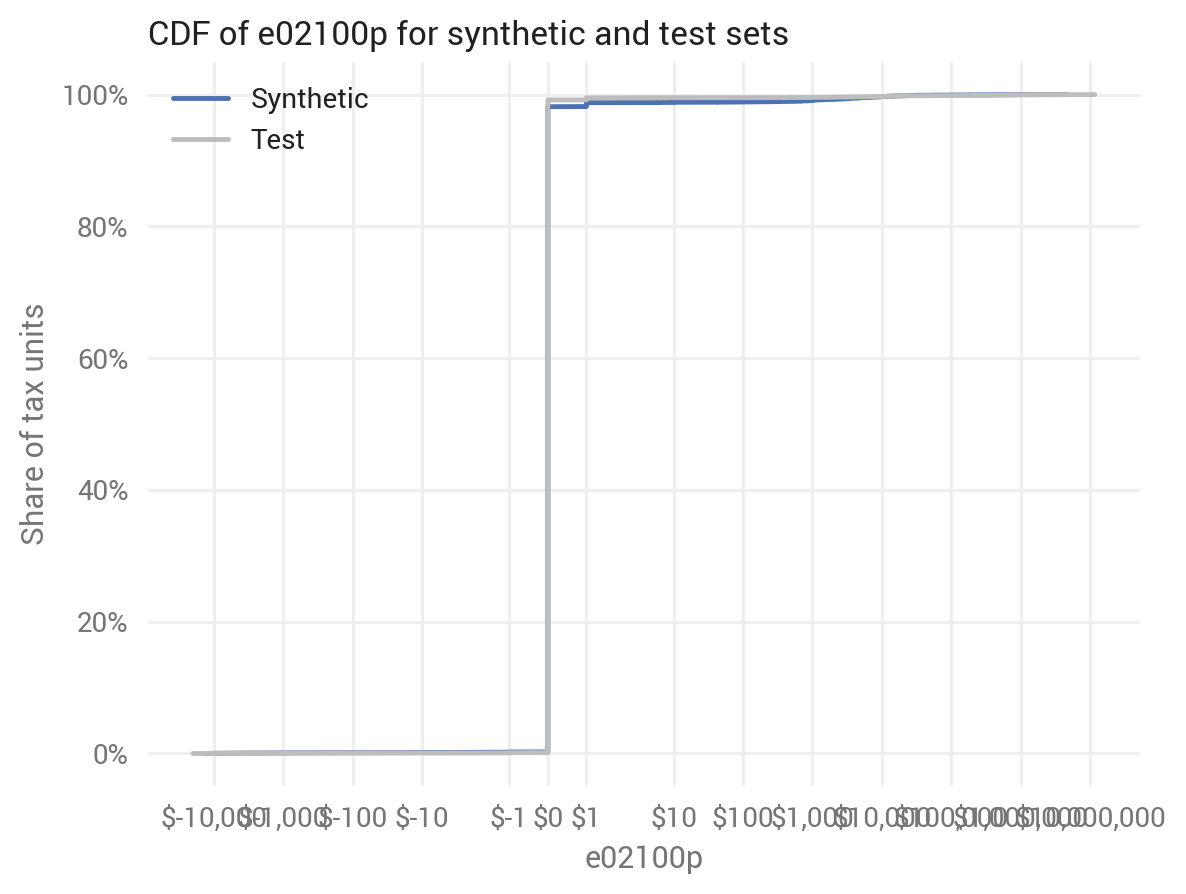

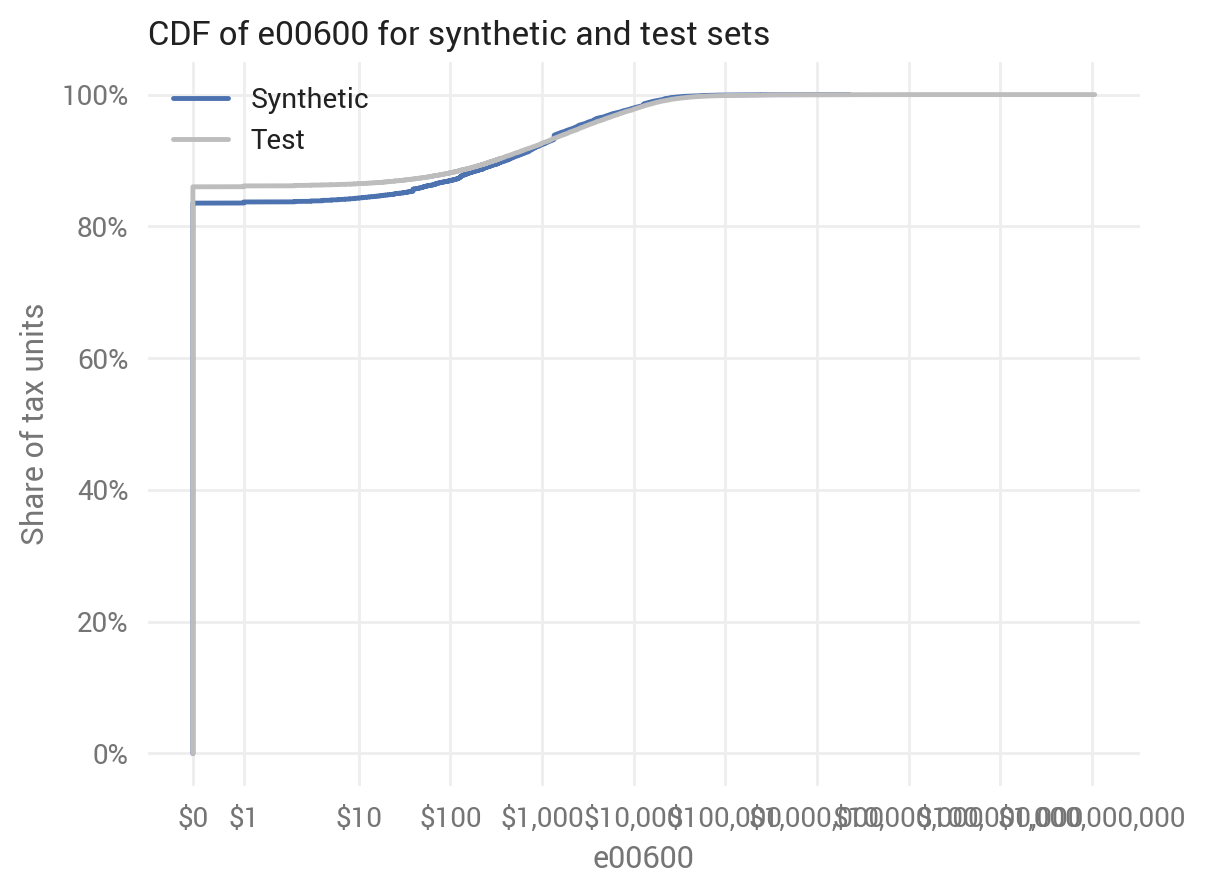

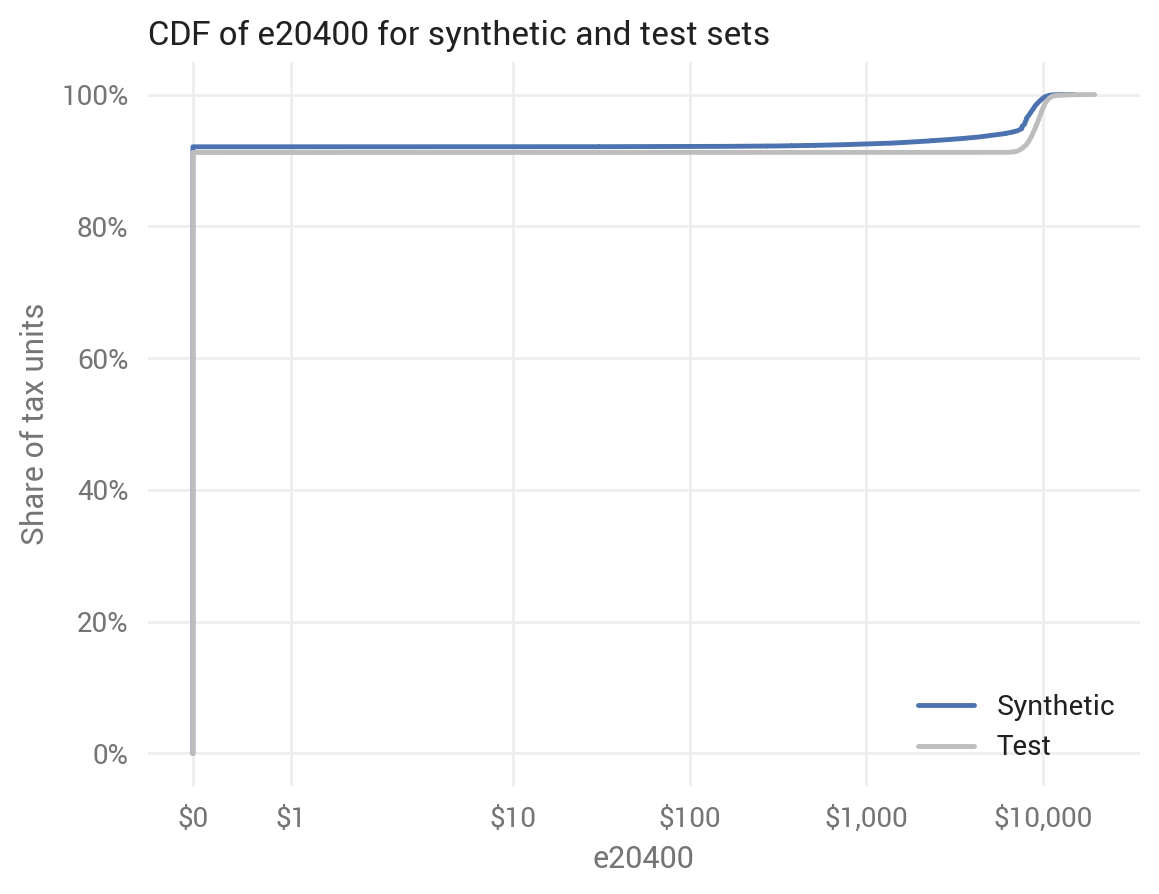

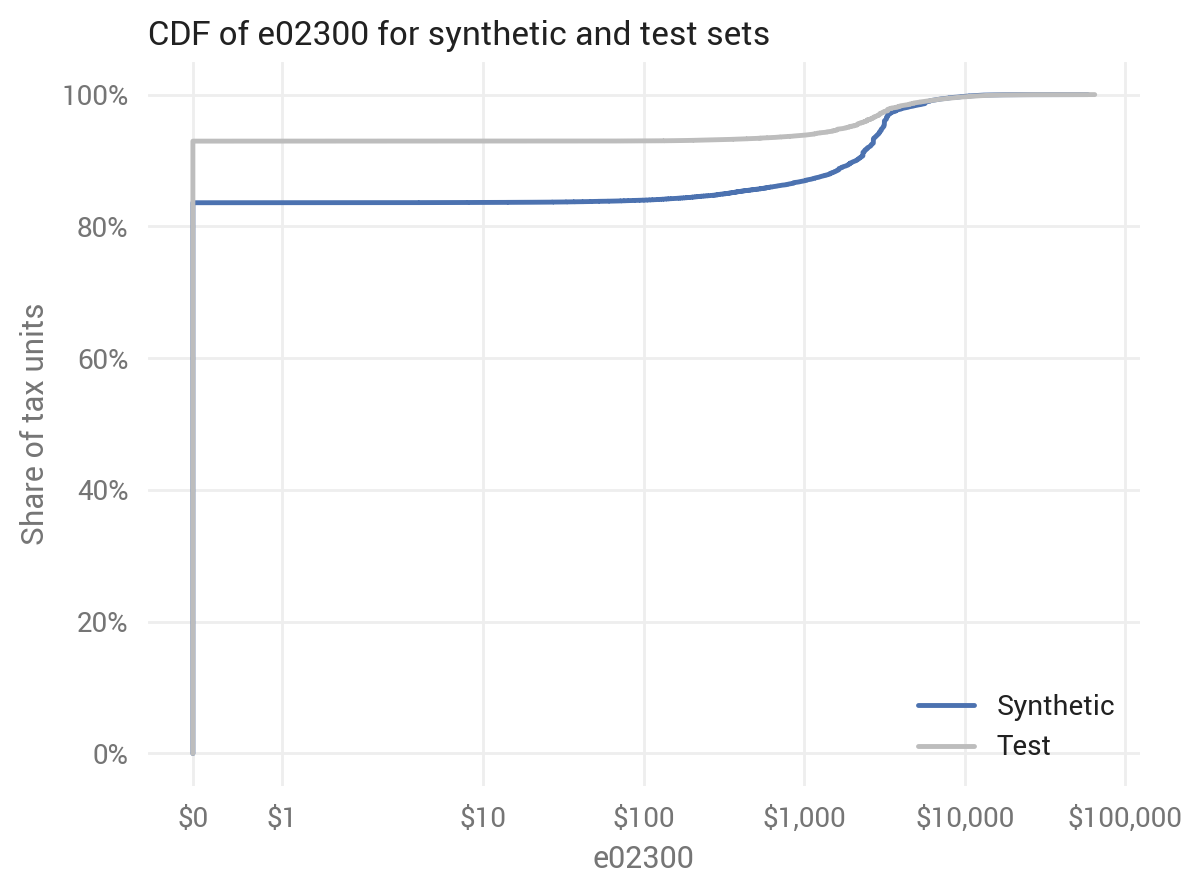

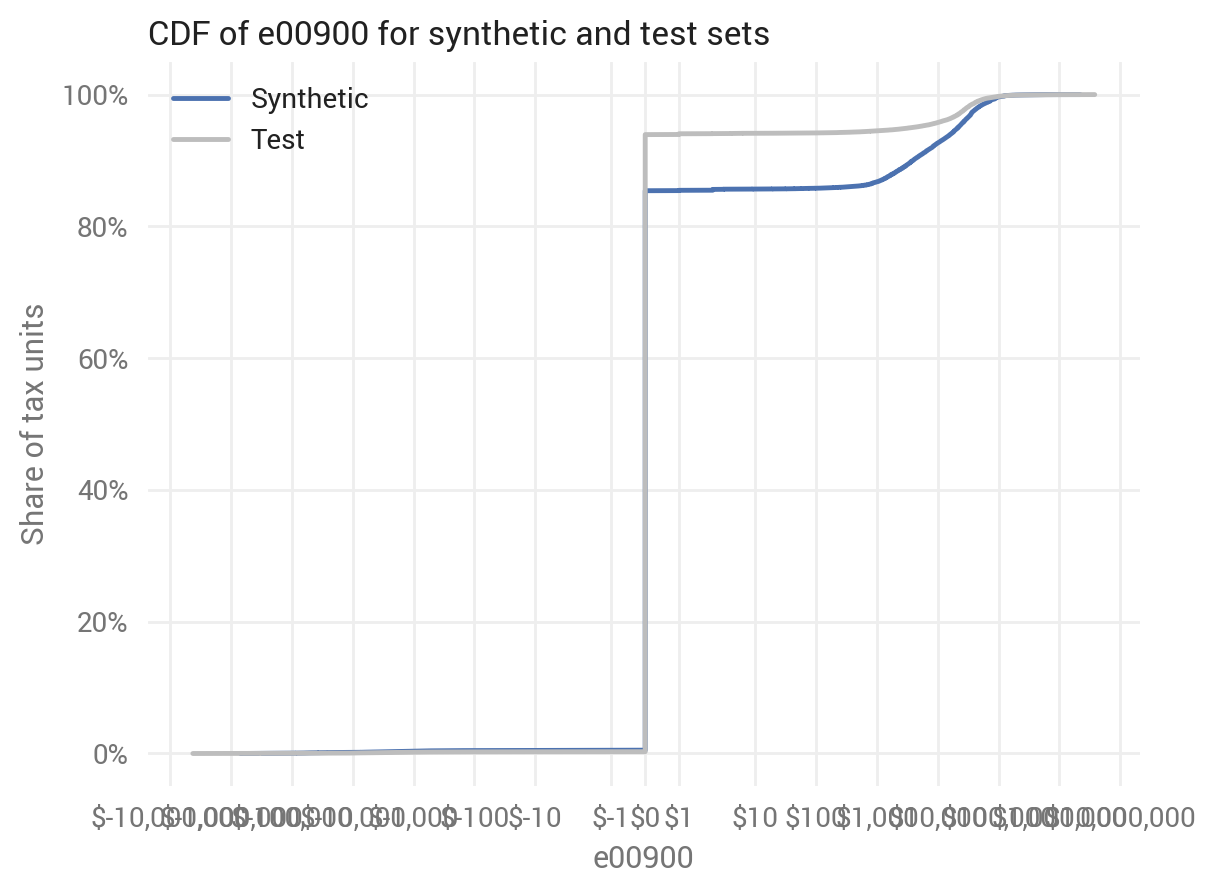

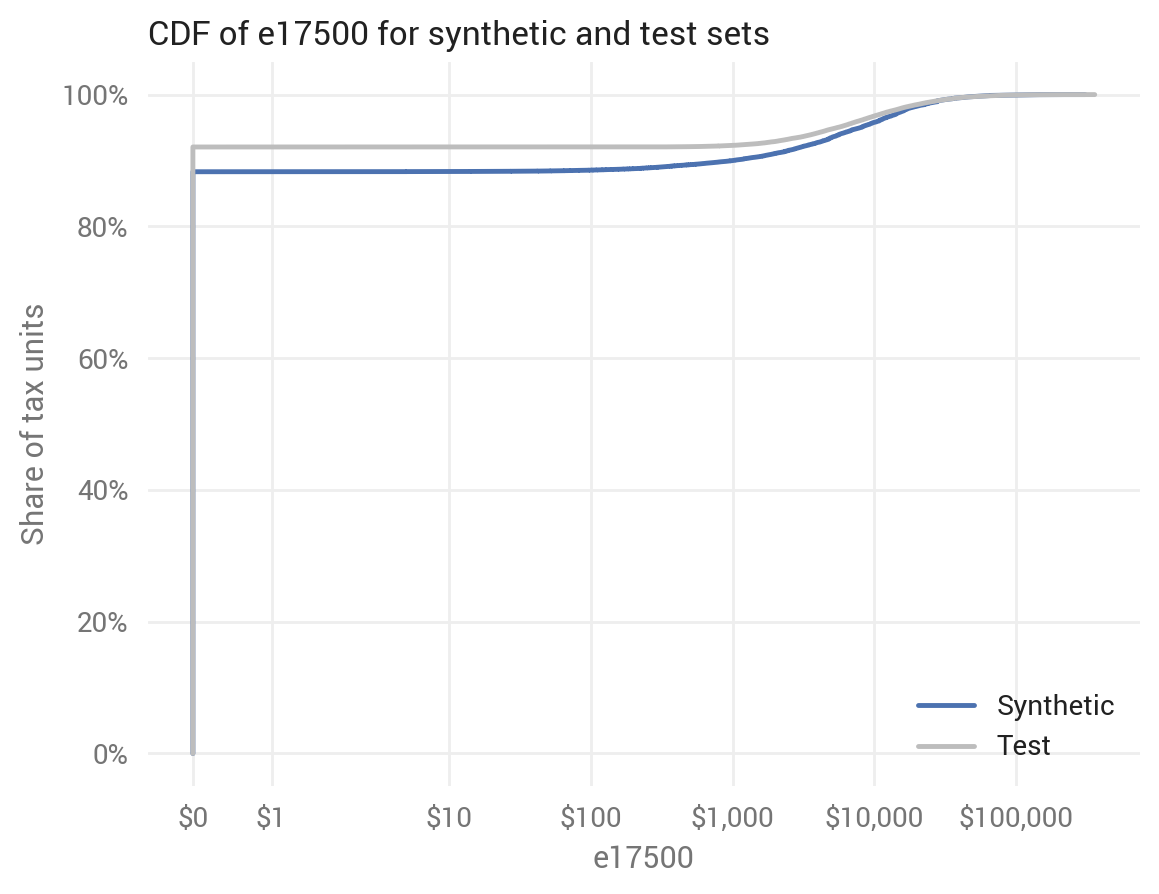

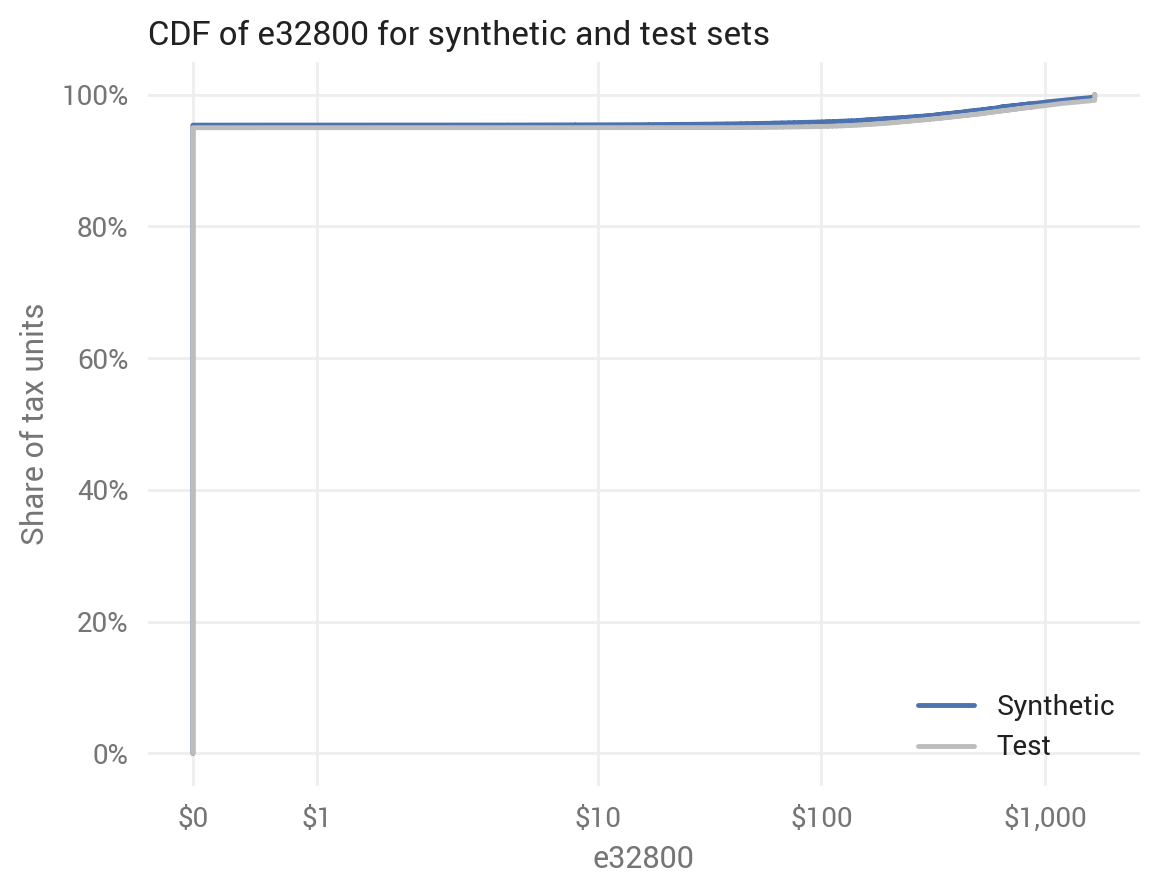

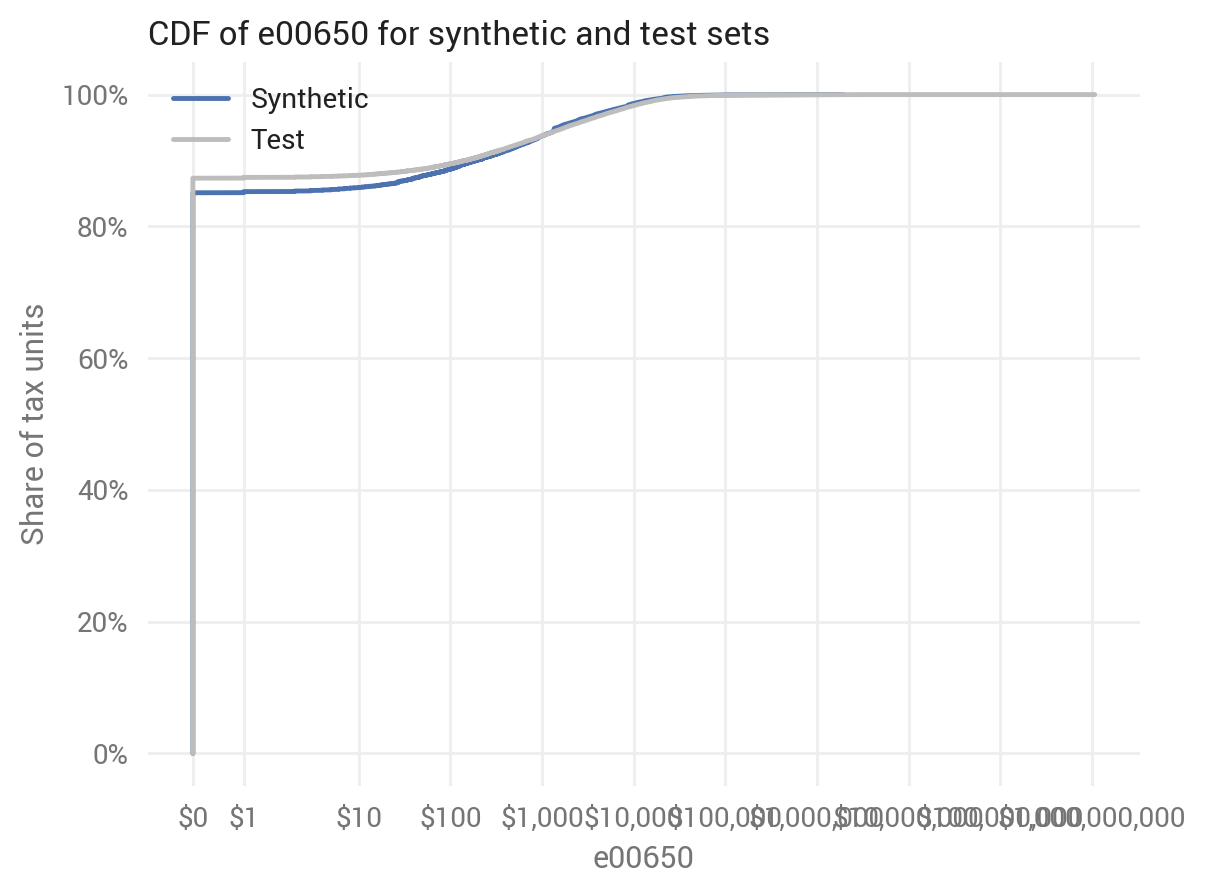

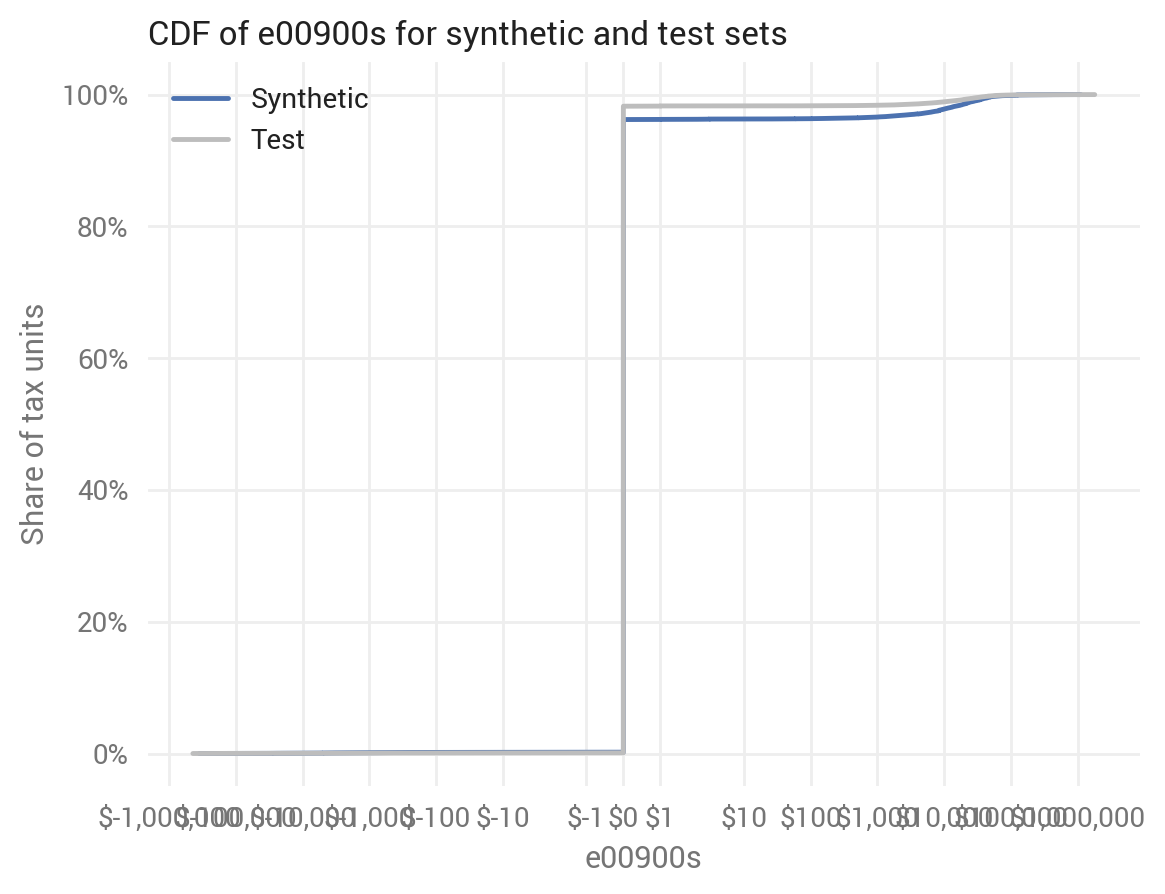

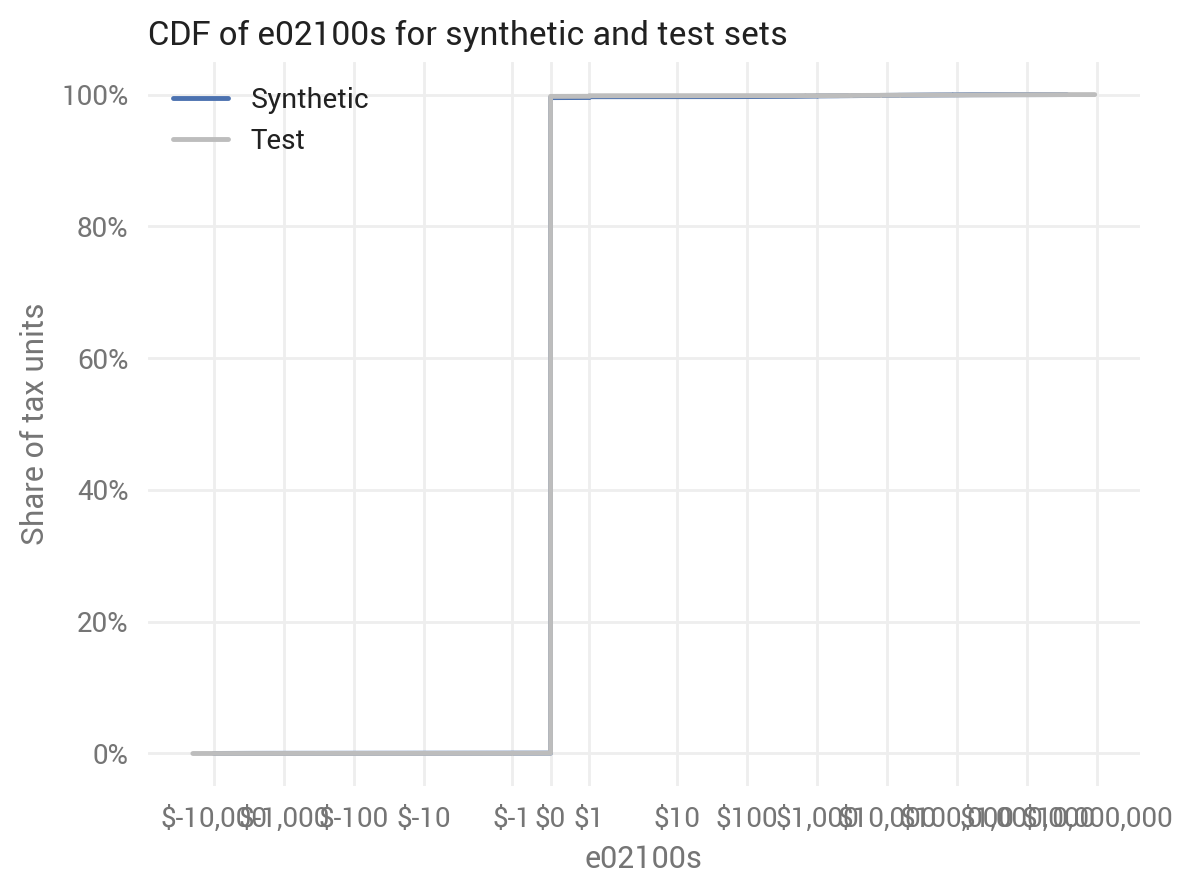

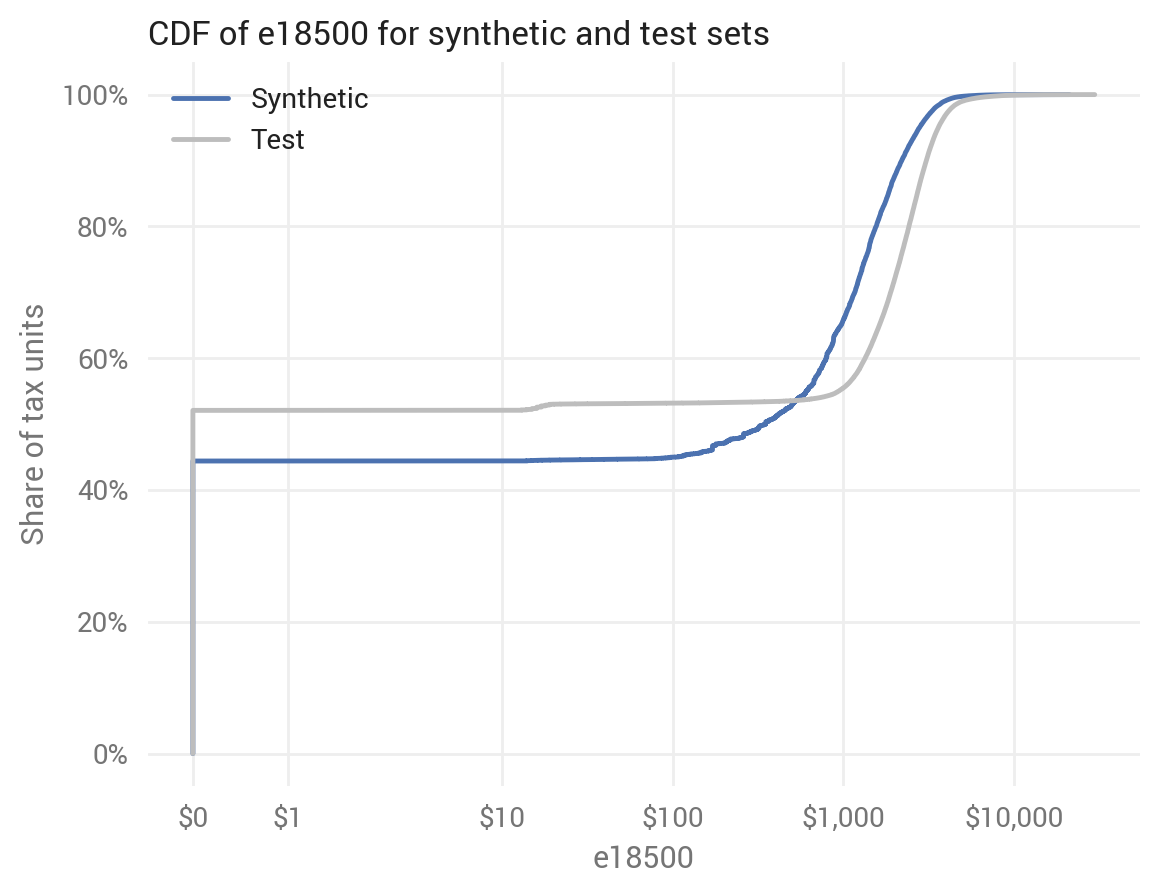

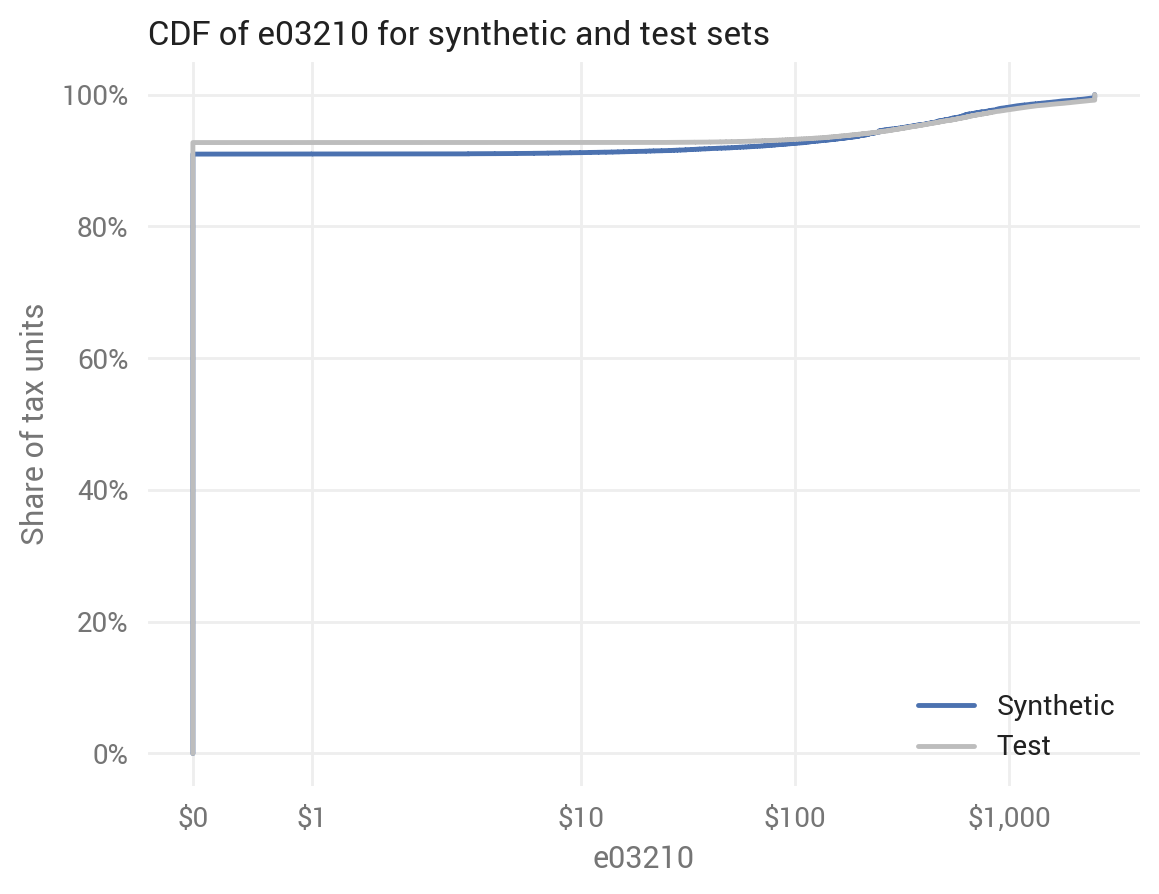

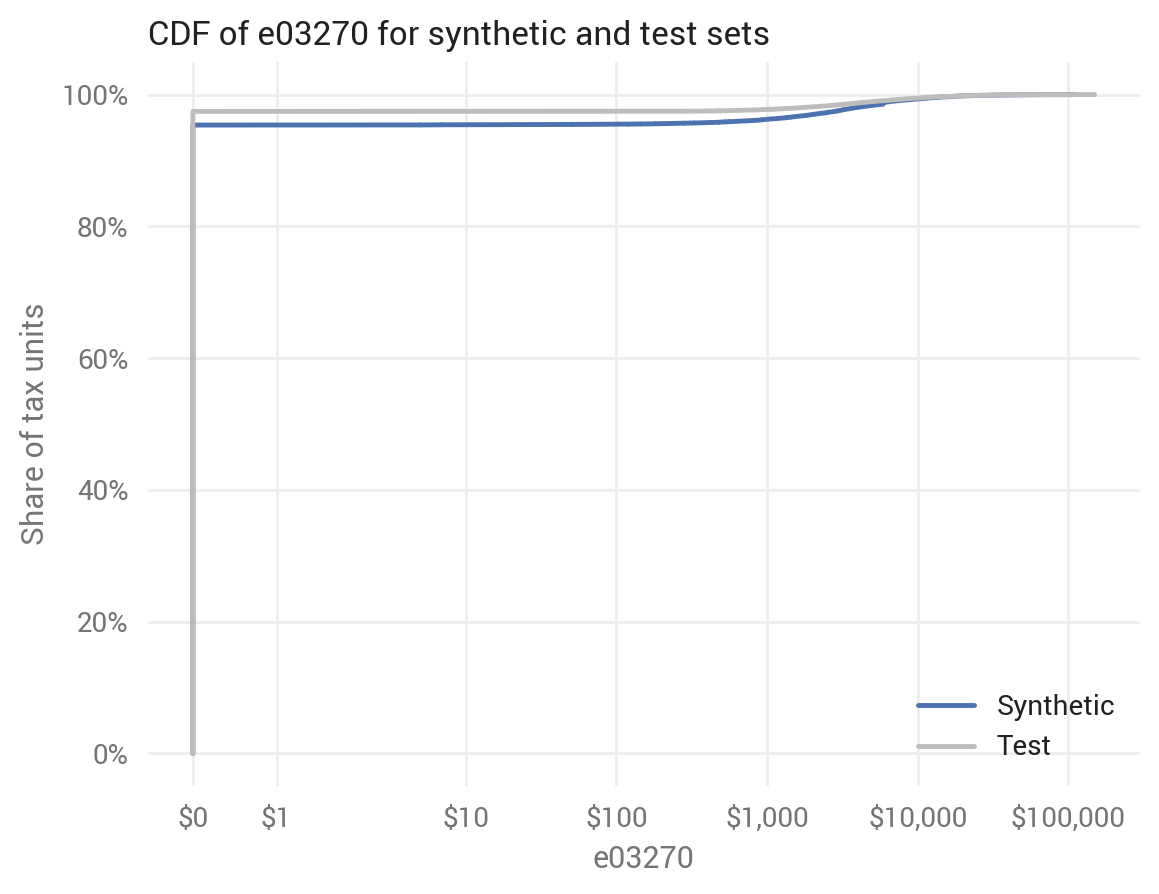

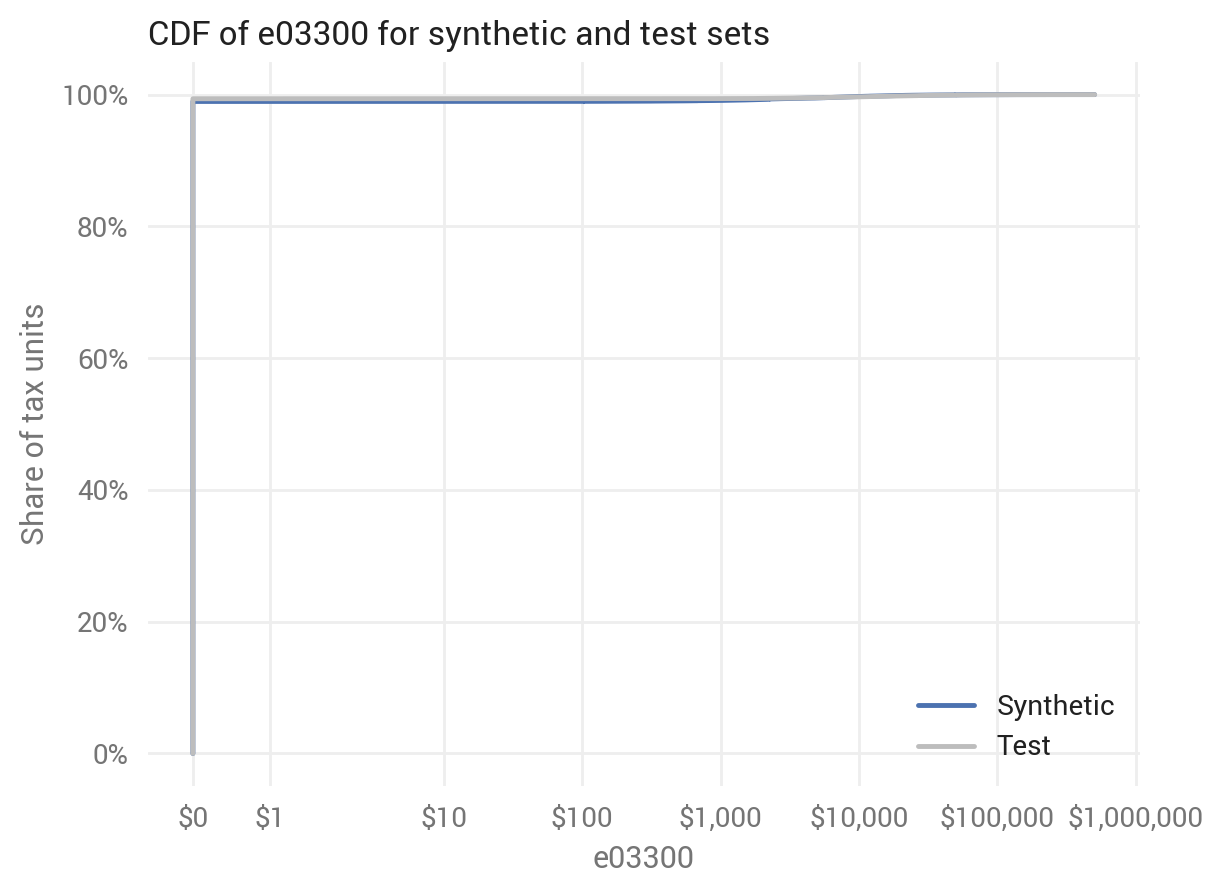

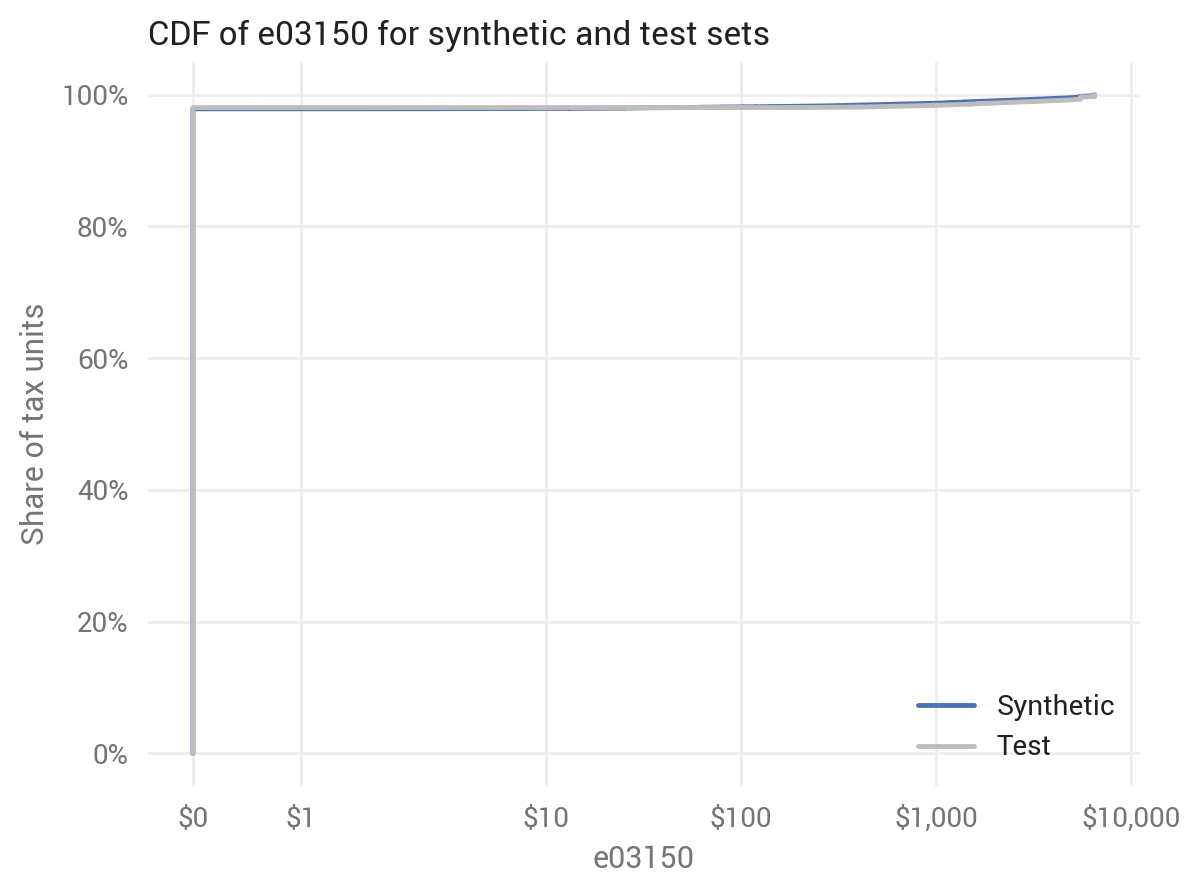

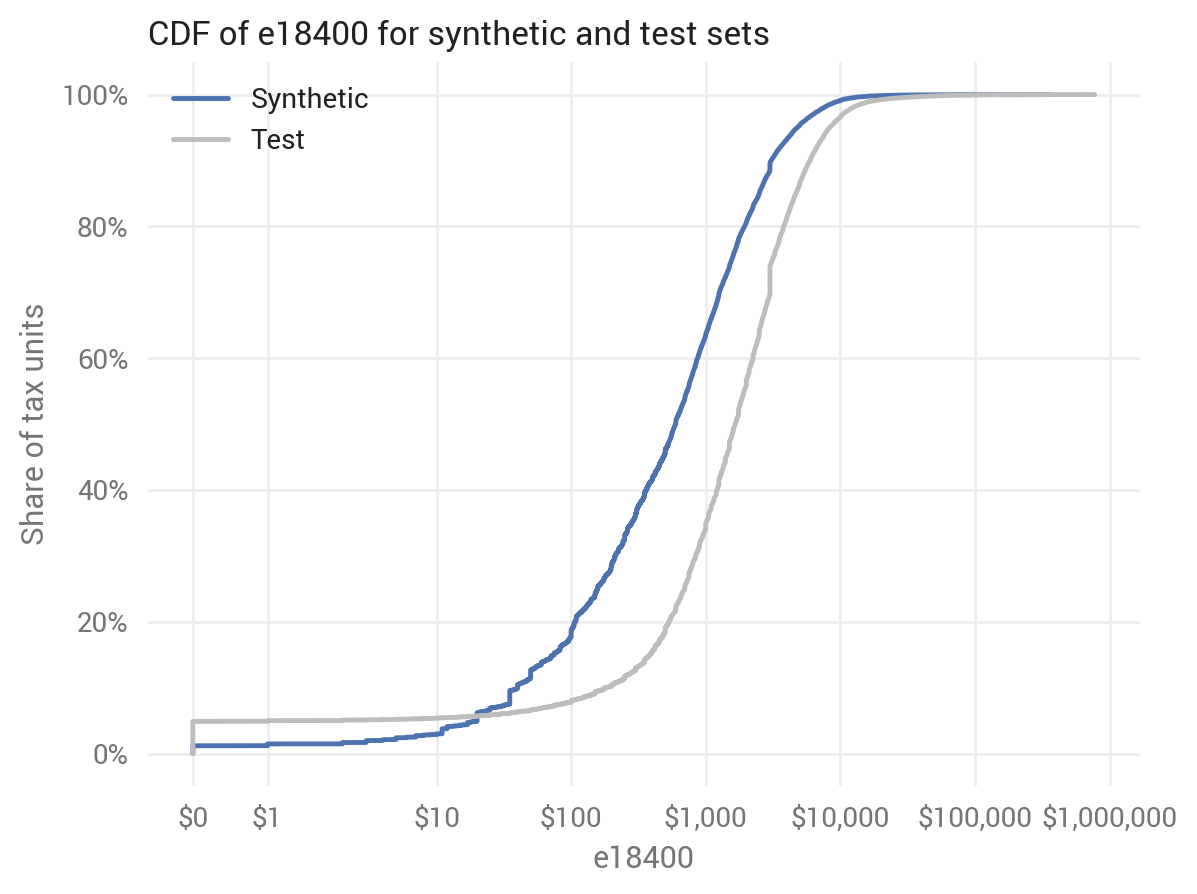

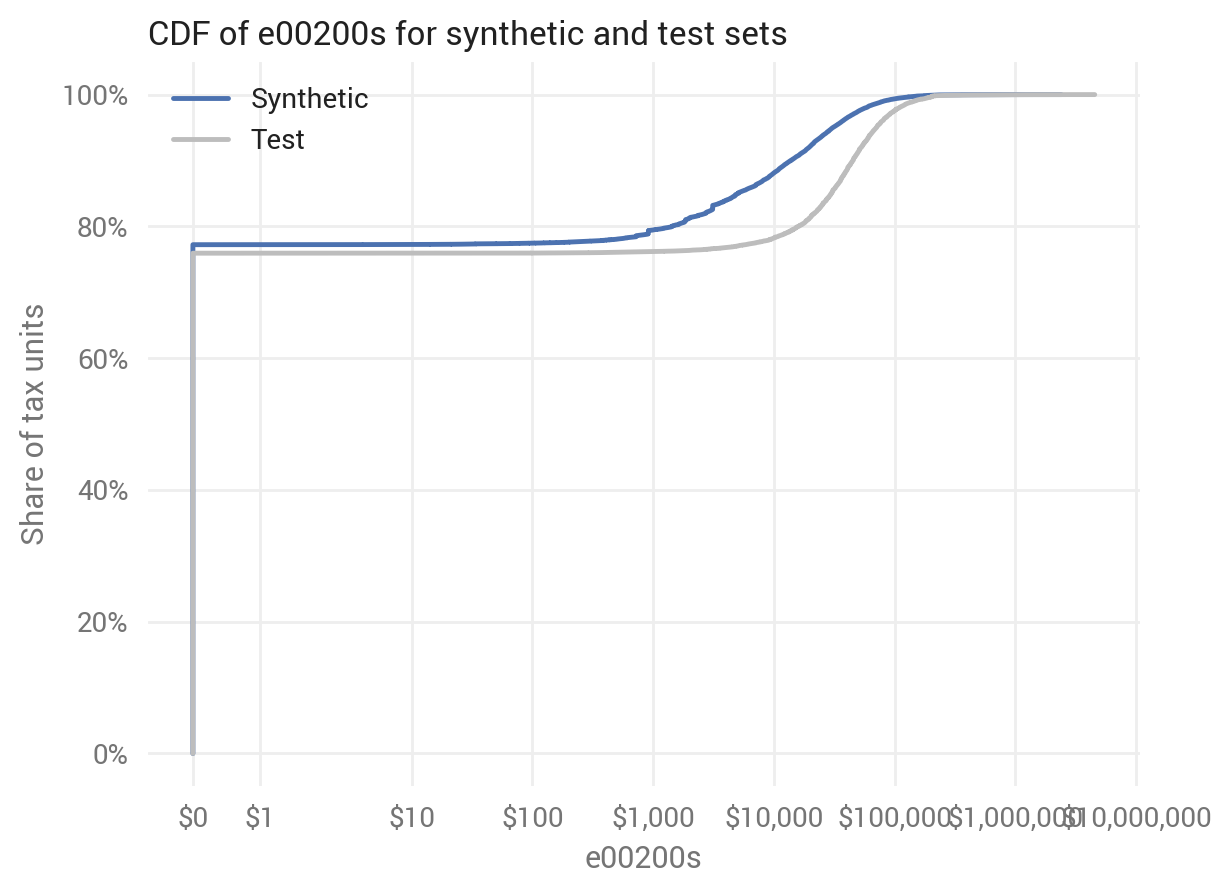

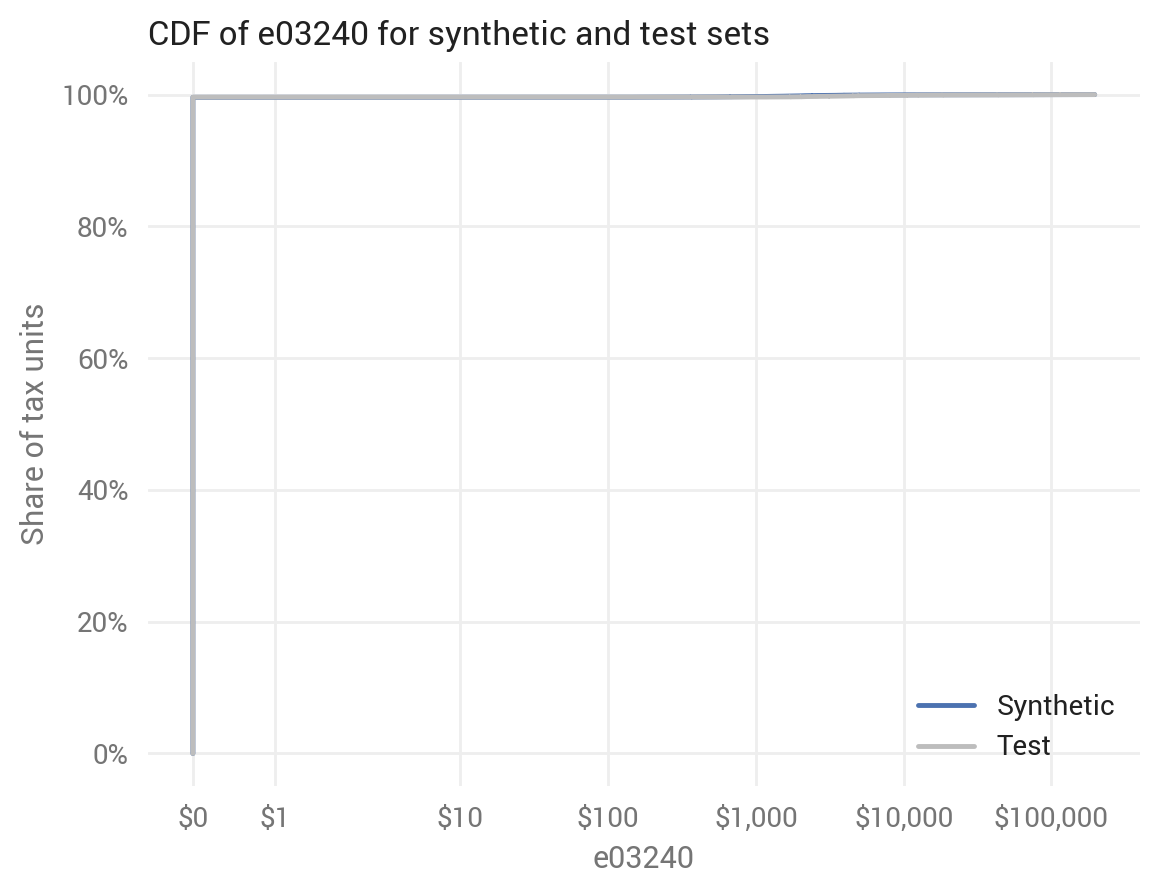

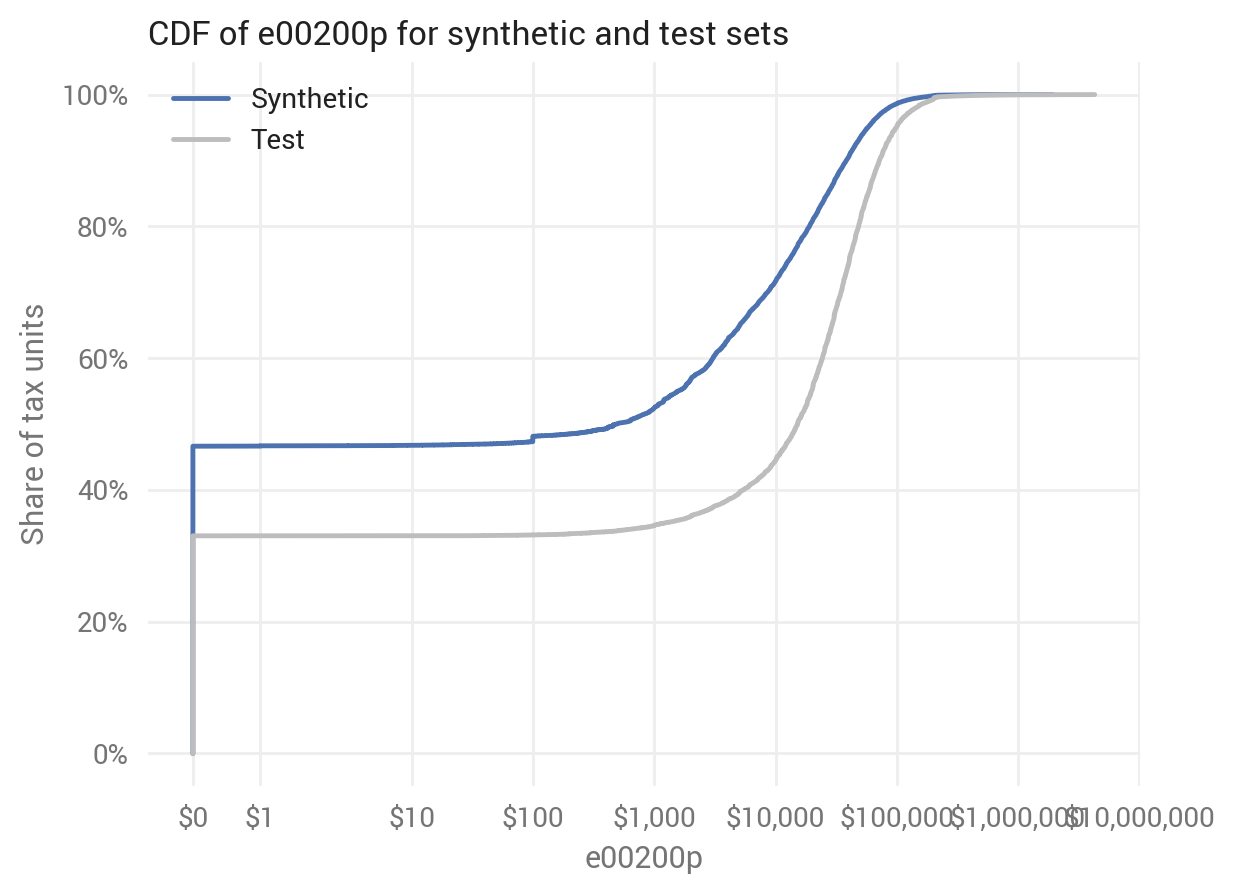

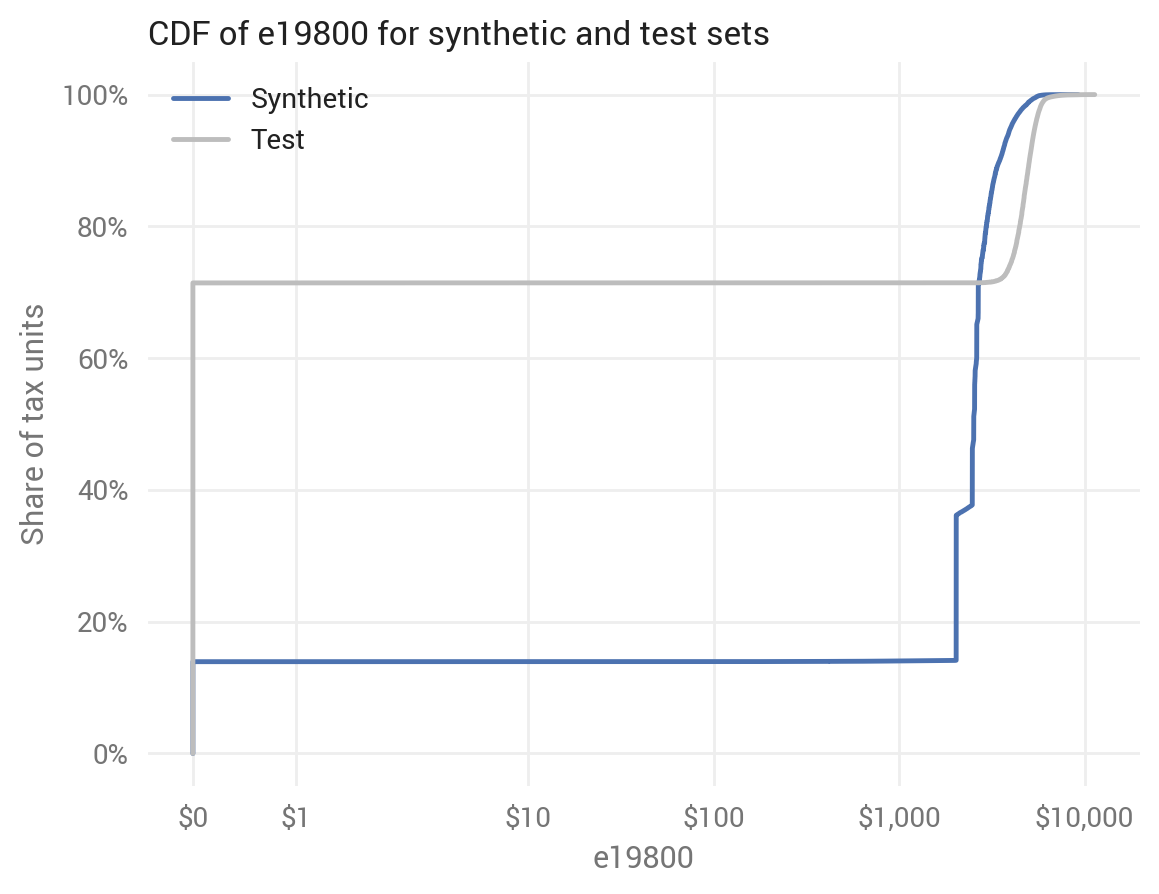

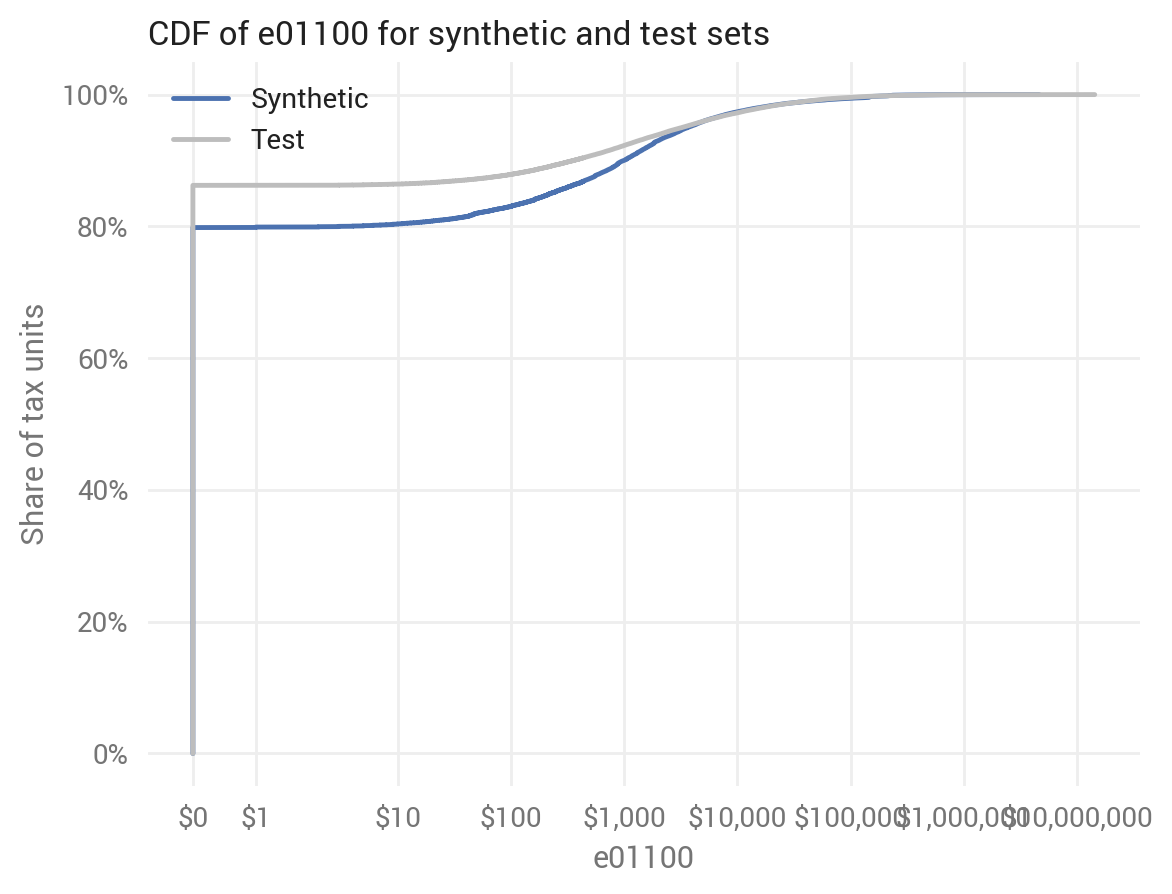

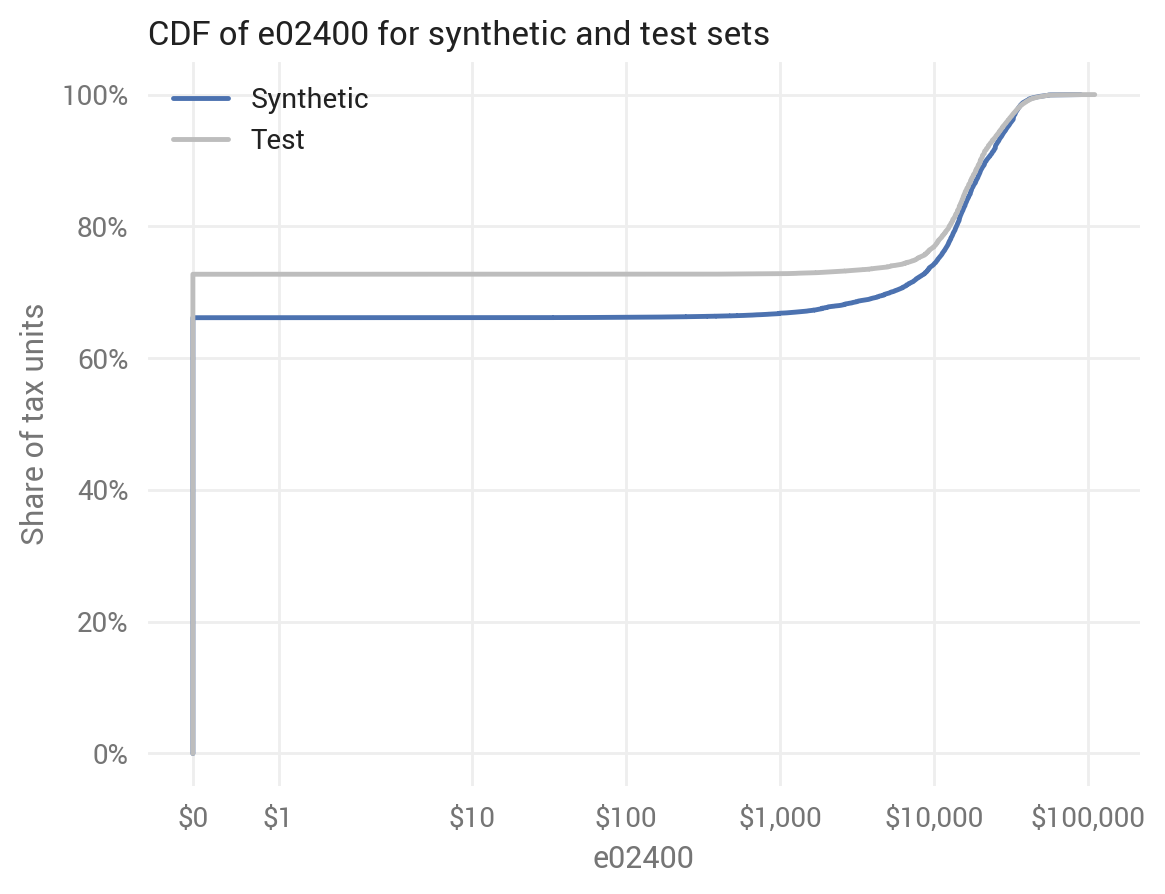

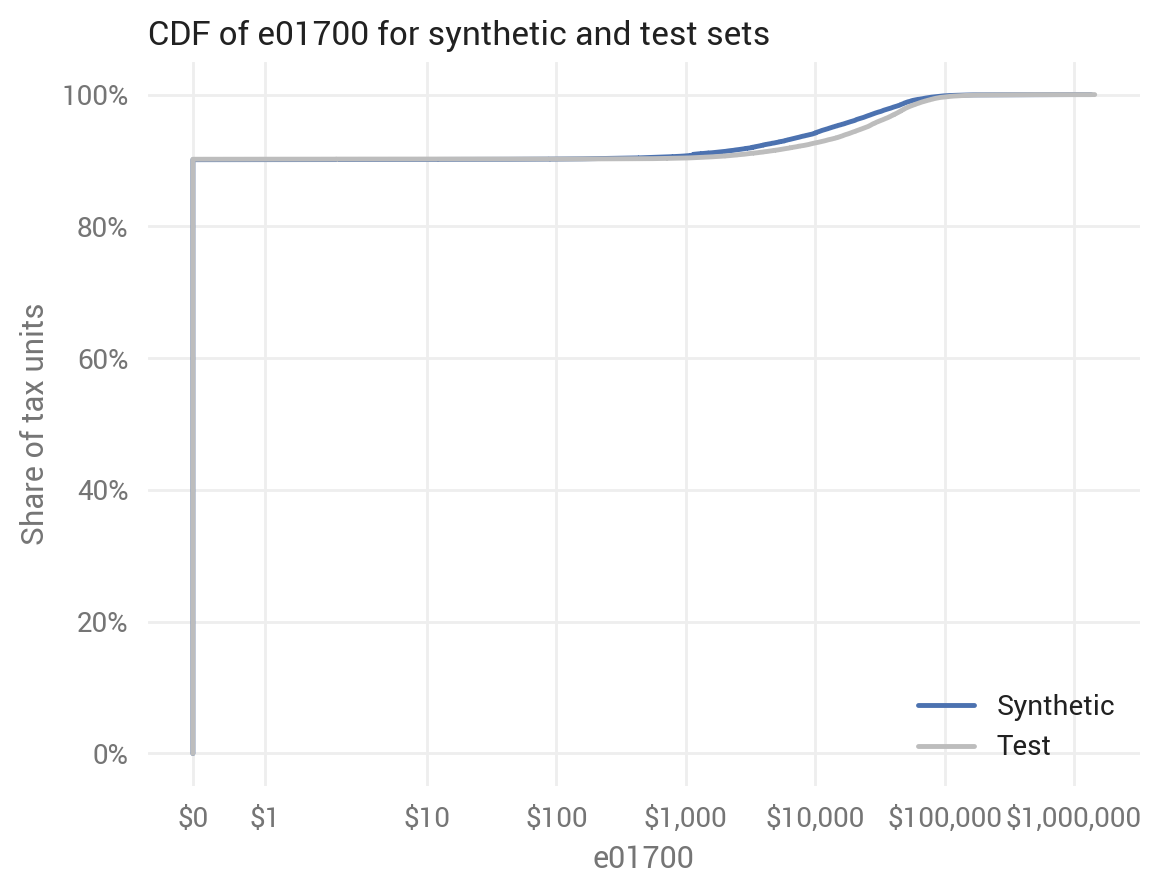

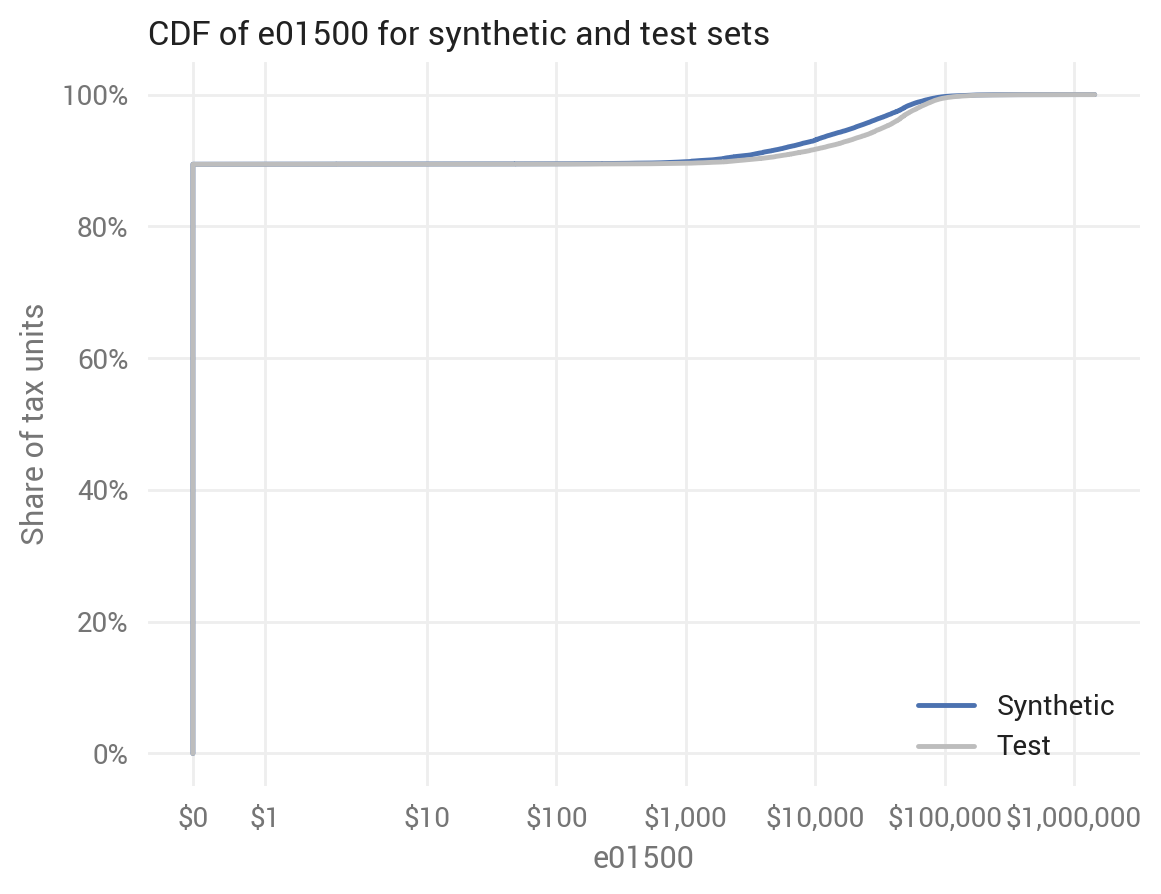

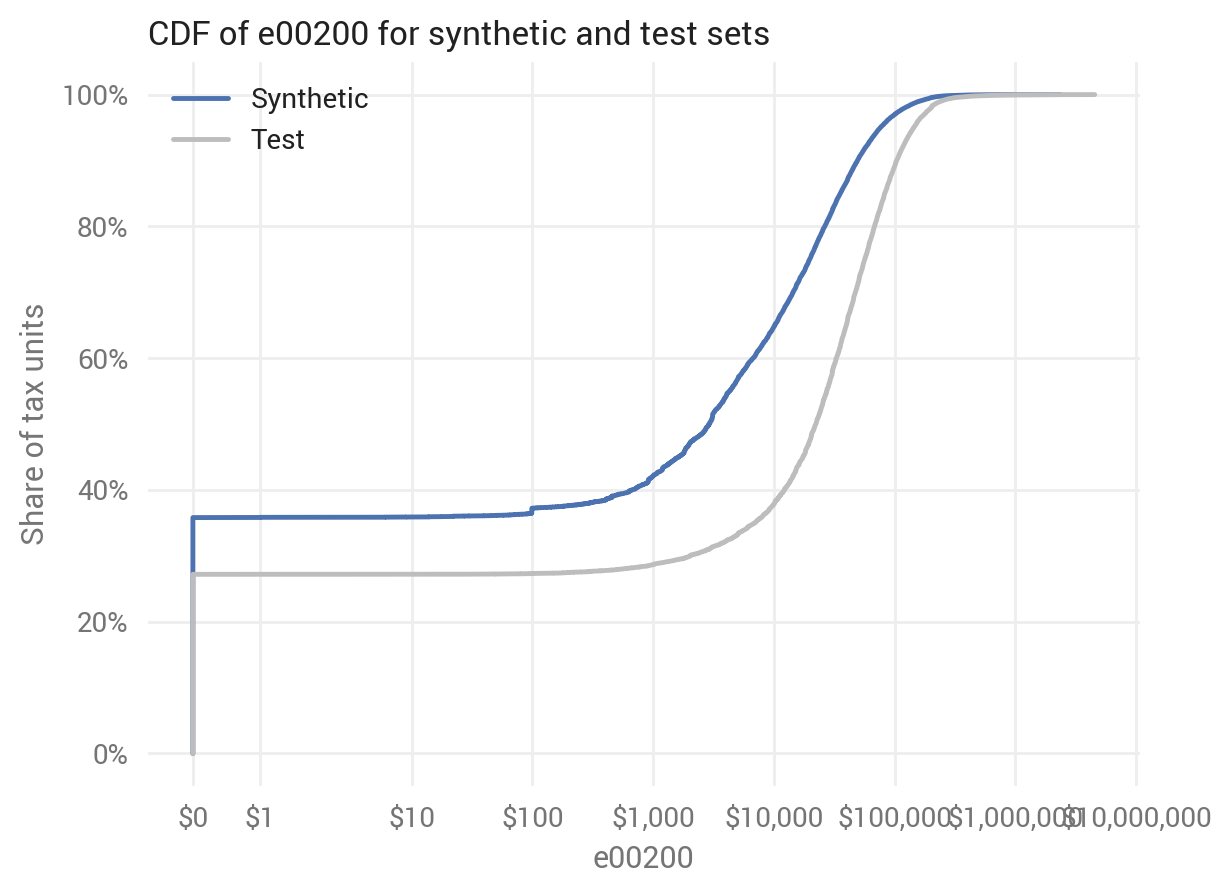

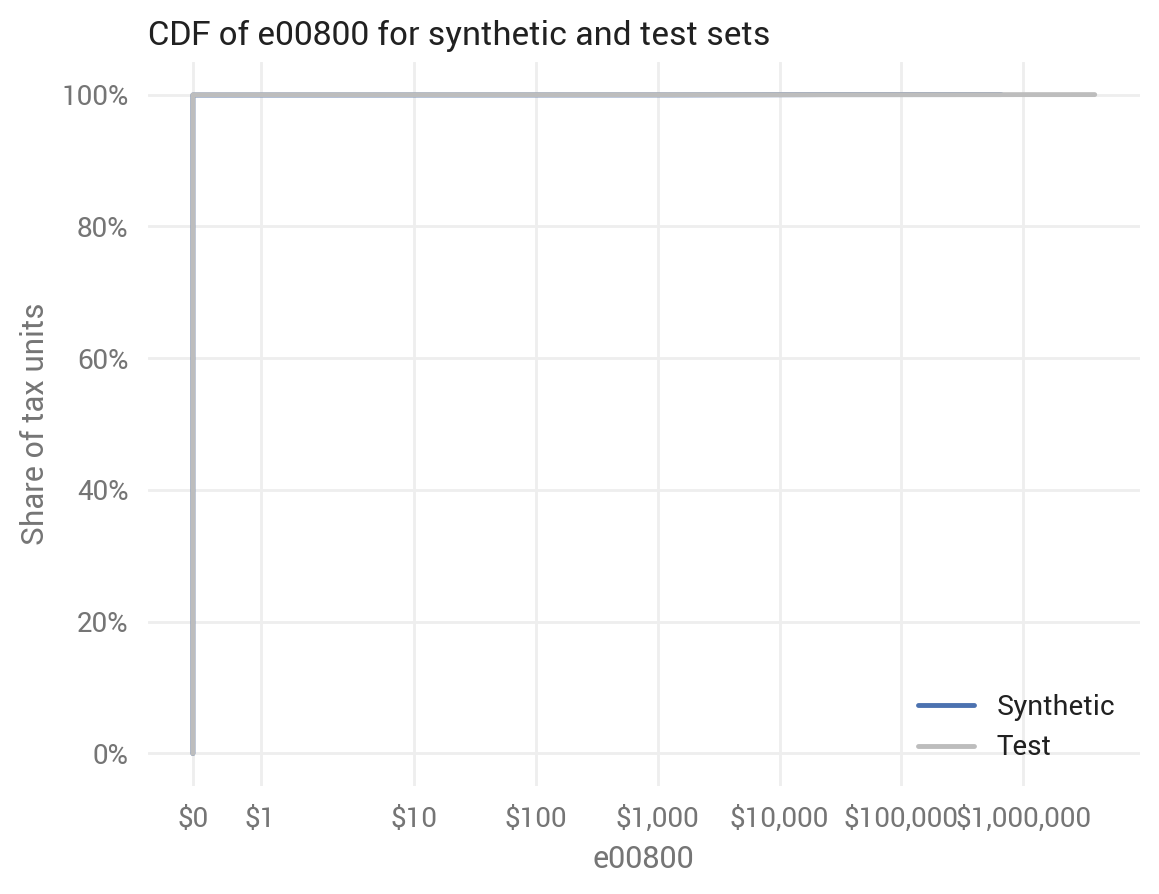

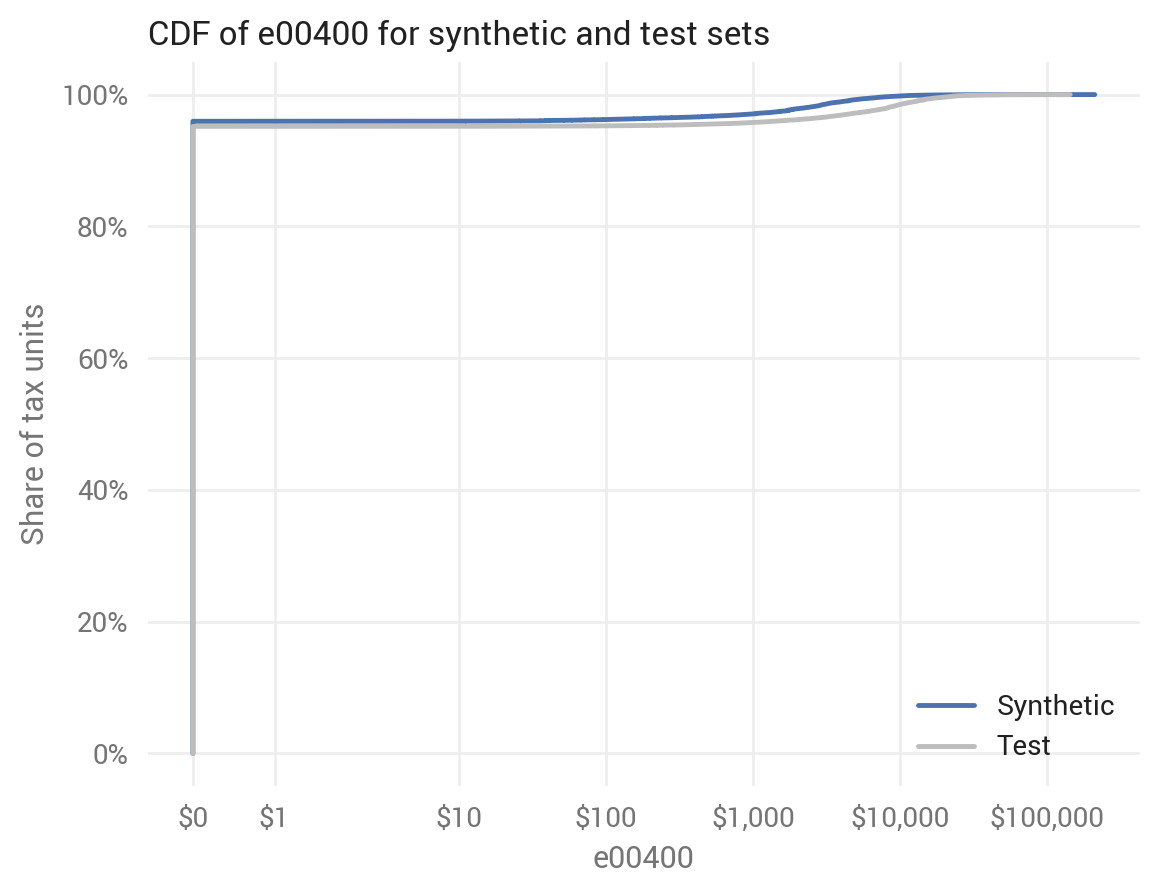

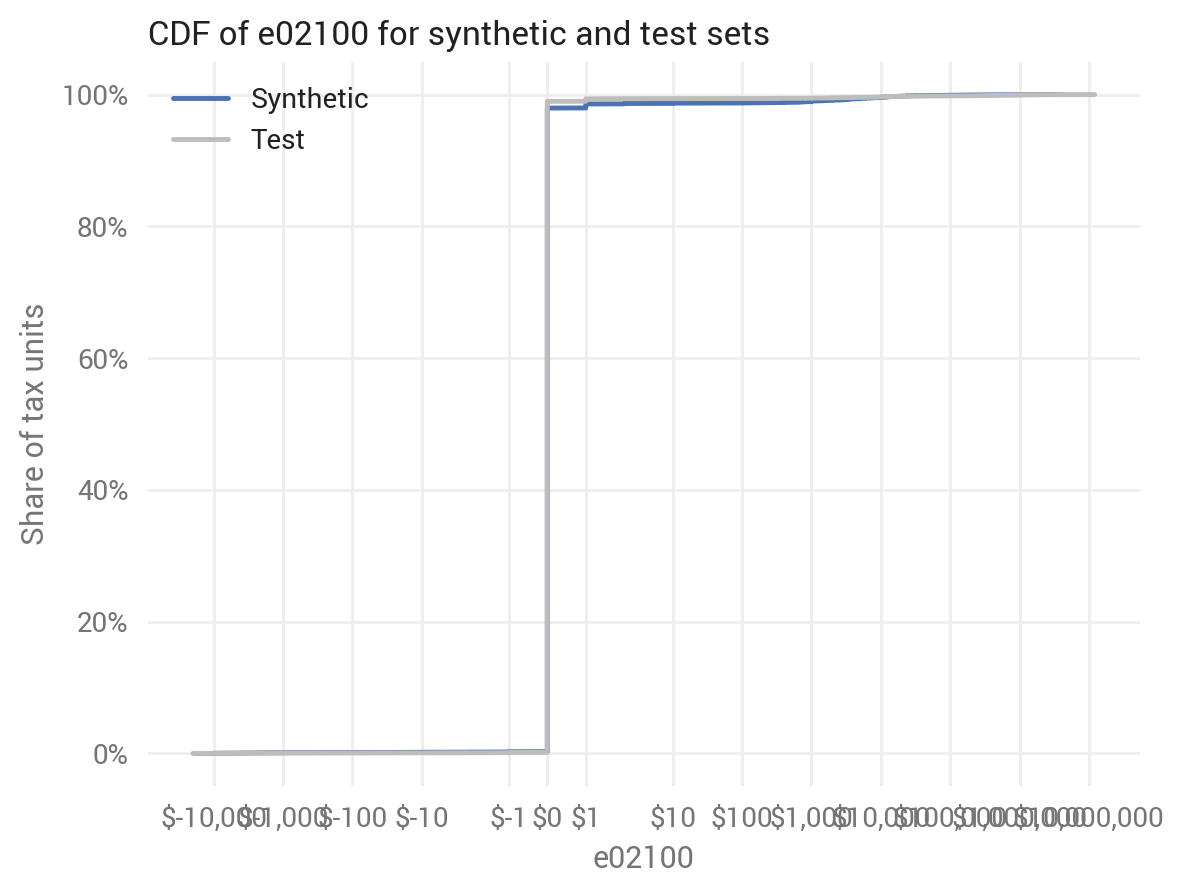

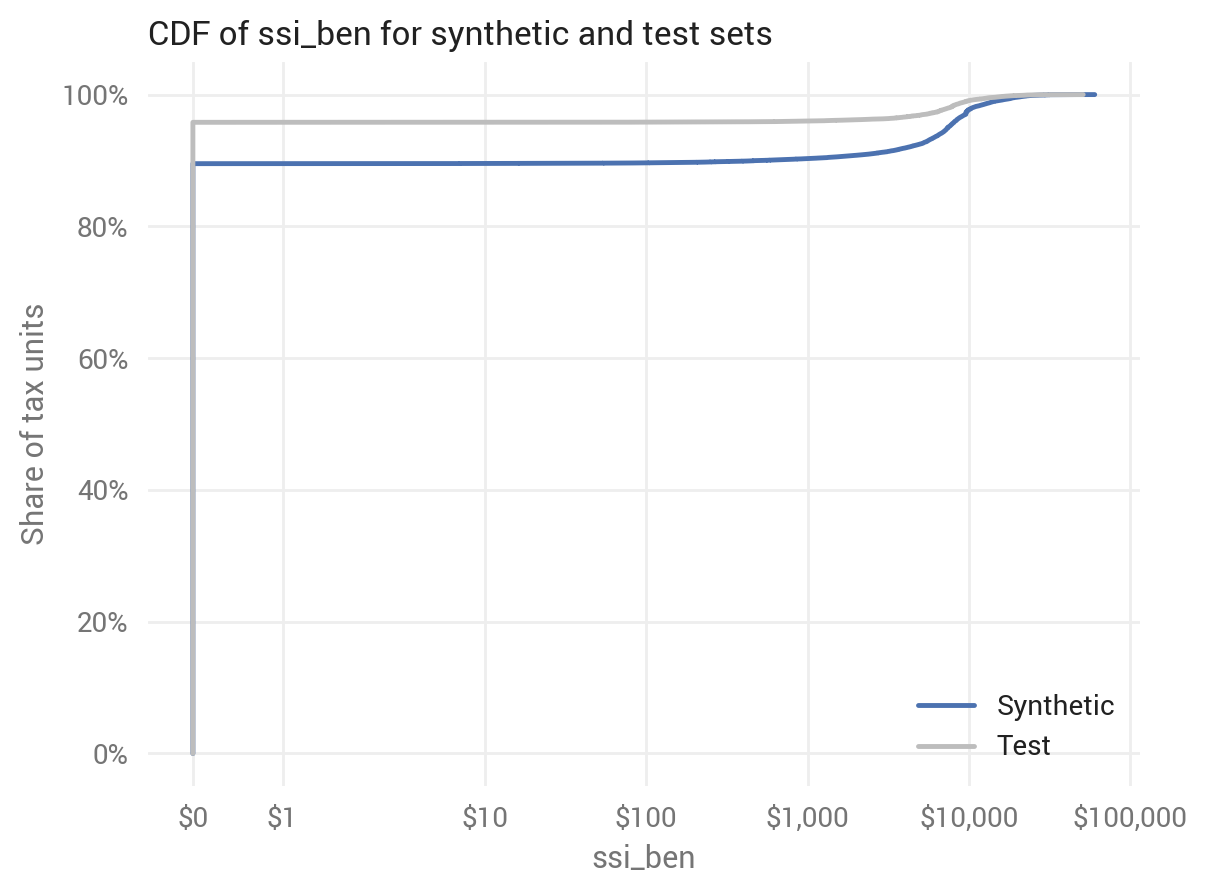

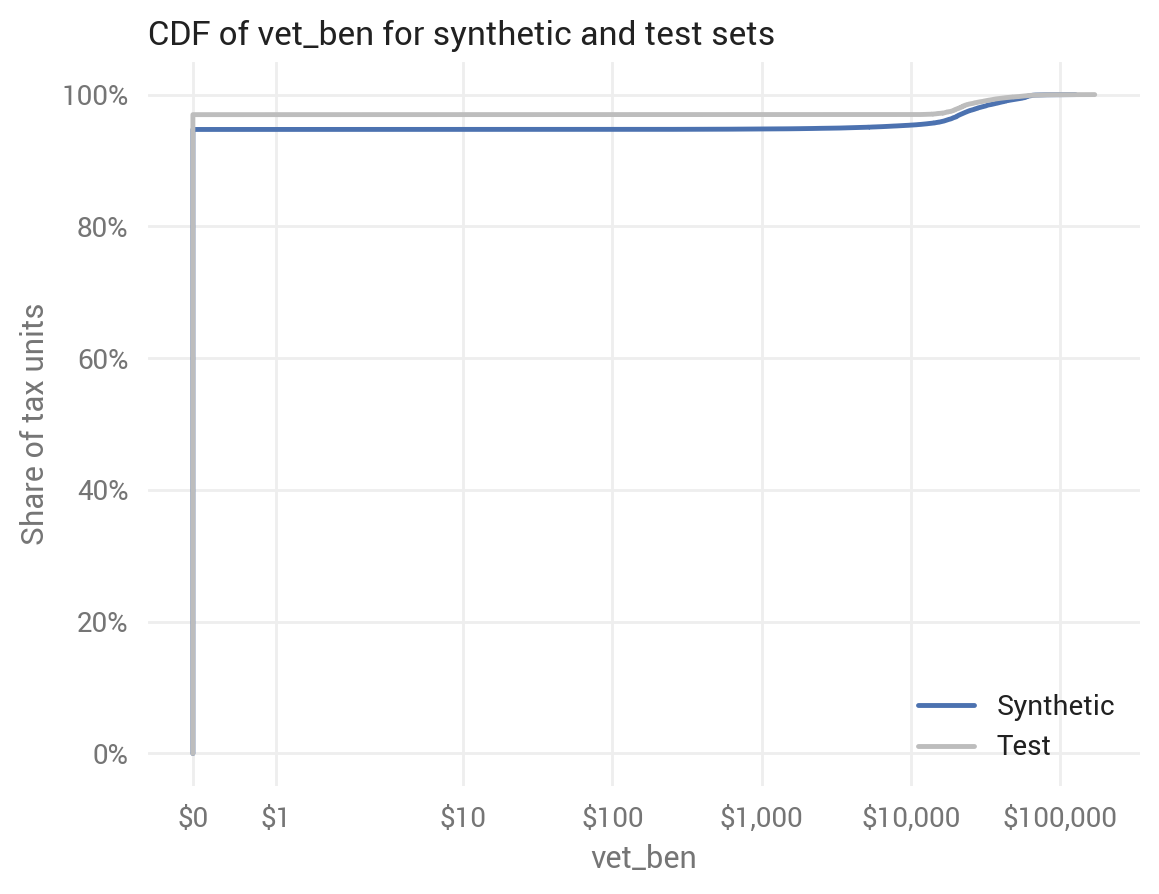

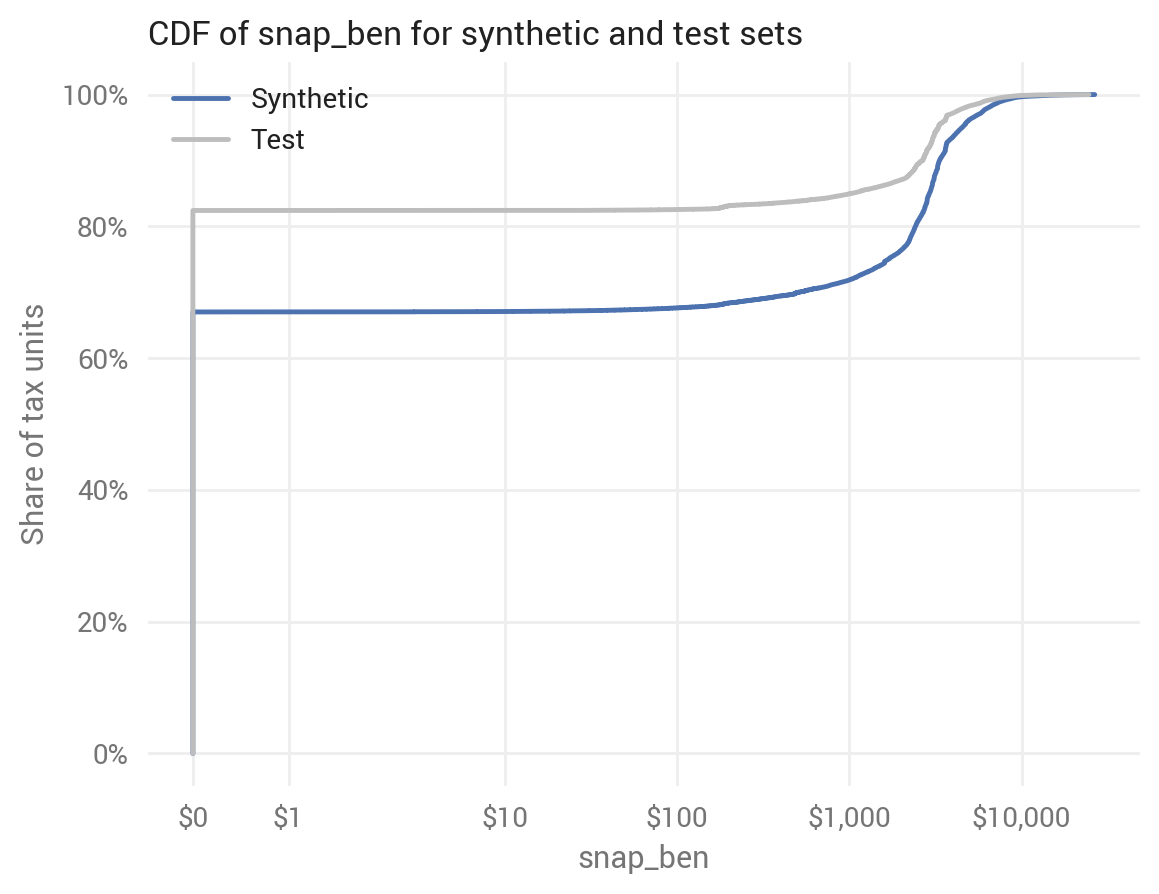

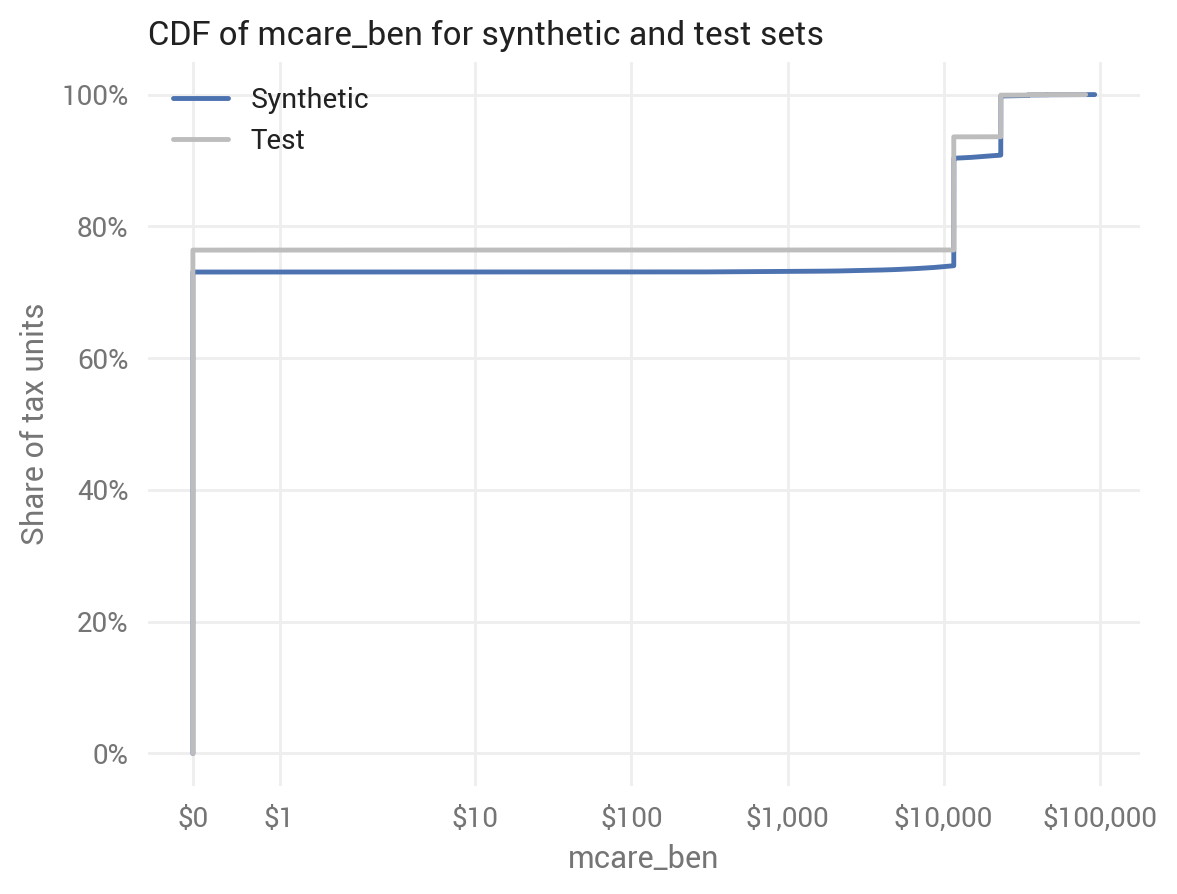

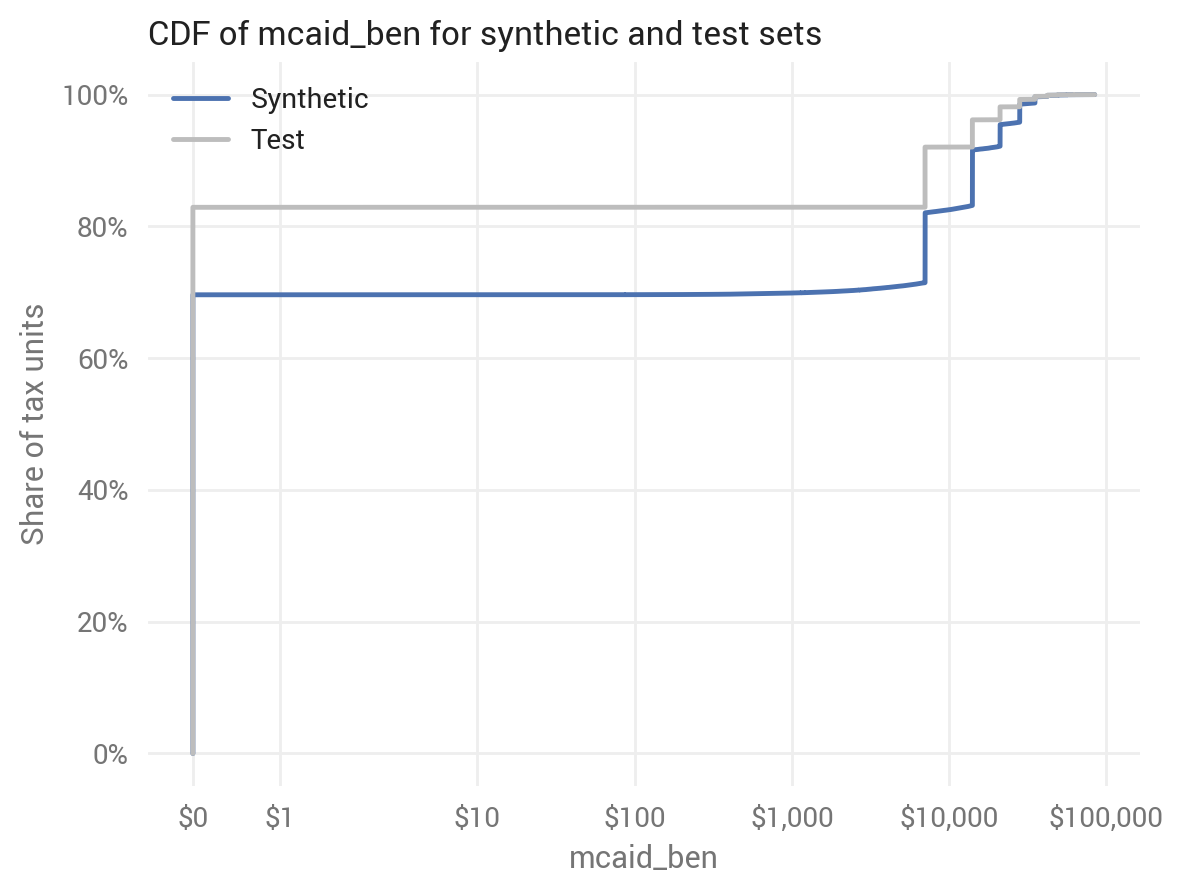

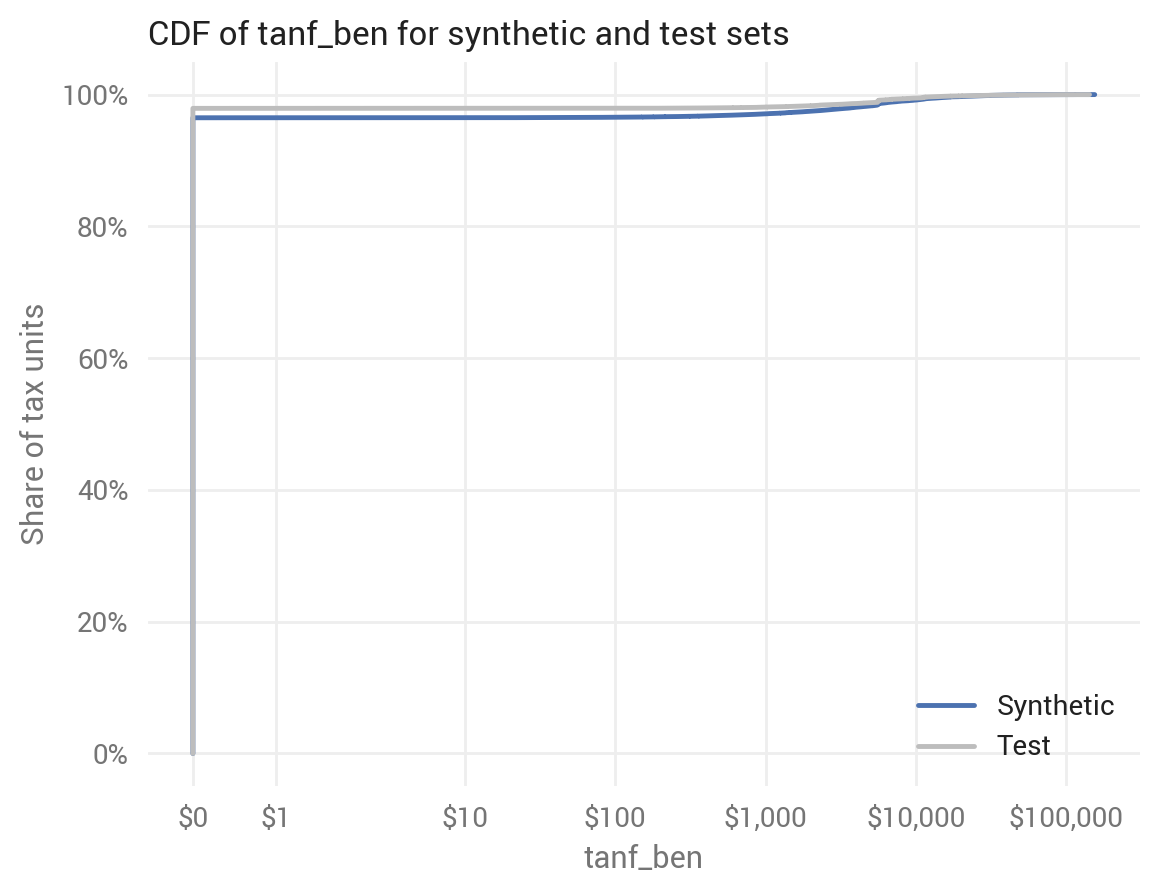

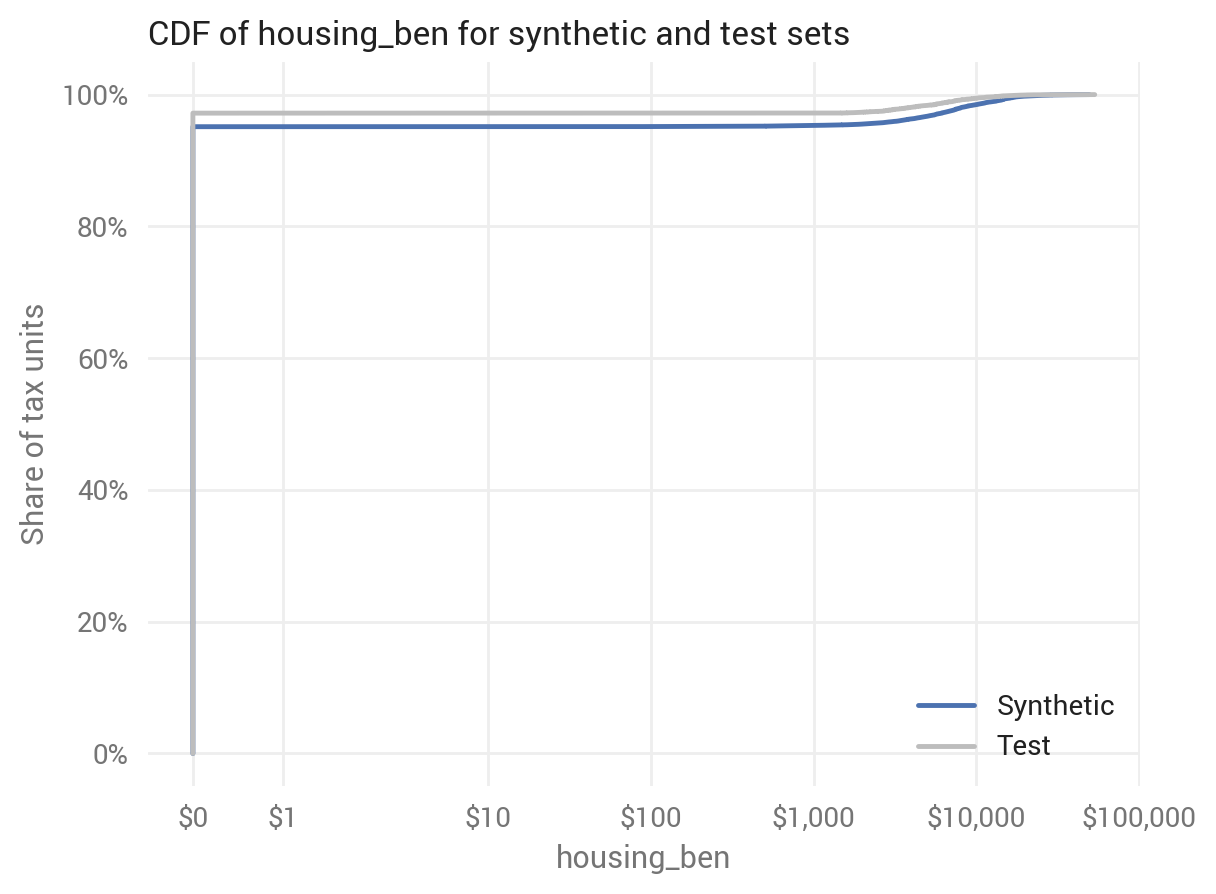

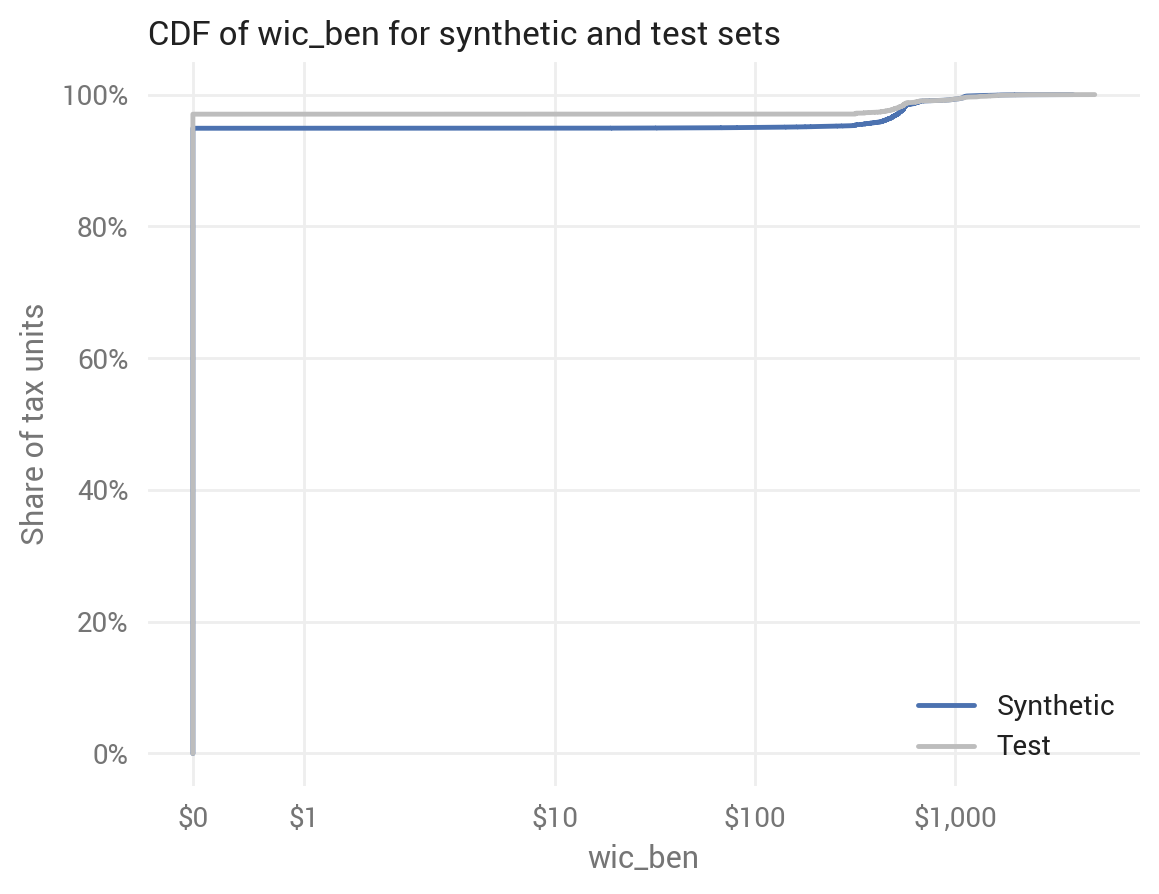

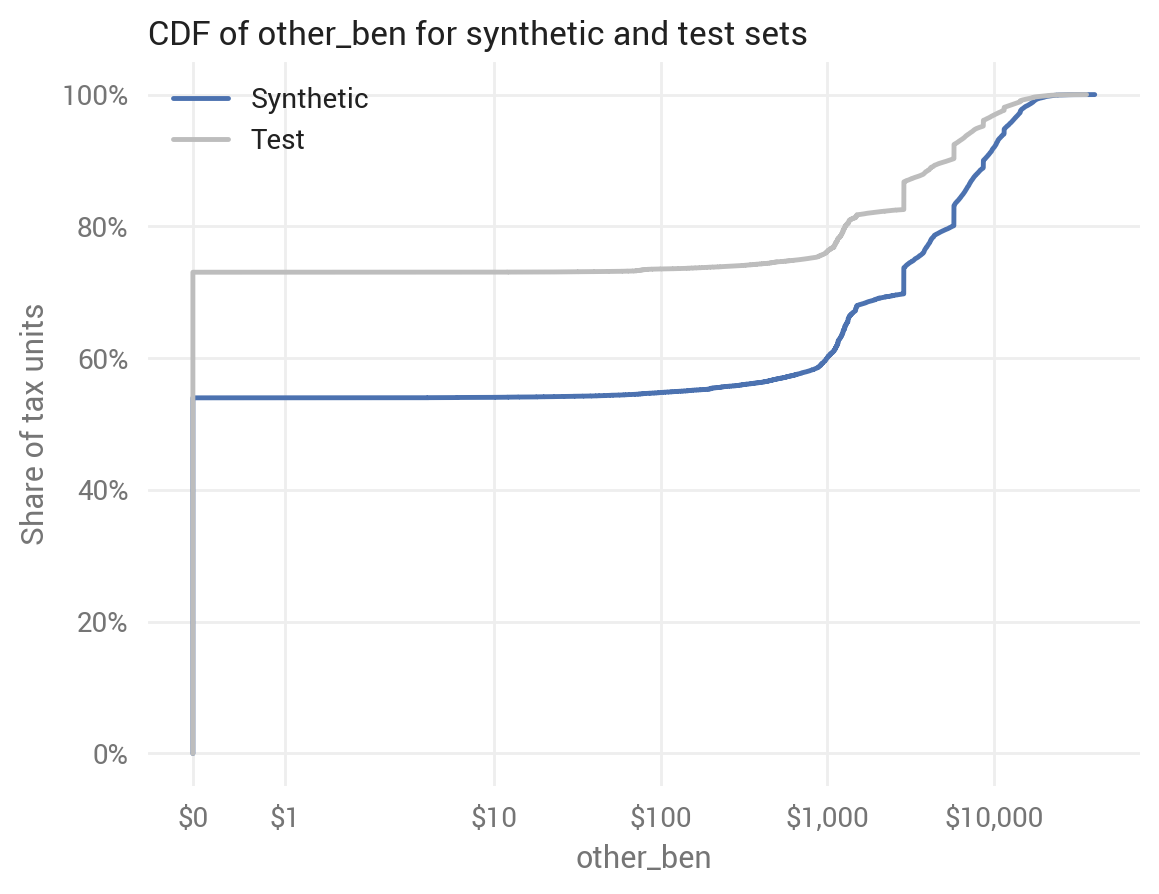

ValueError: ignored

In [24]:
for i in rf_vars:
  compare_cdf(synthr, test, i)